In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 304)
(1919620, 8)
validation
(288502, 304)
(288502, 8)
test
(221128, 304)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 304)]             0         


 dense (Dense)               (None, 1024)              312320    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1002376 (3.82 MB)


Trainable params: 1002376 (3.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 1:49 - loss: 2.4408 - STD: 0.1036 - MAE: 0.2184

 2/20 [==>...........................] - ETA: 2s - loss: 2.3246 - STD: 0.0810 - MAE: 0.2185  

 3/20 [===>..........................] - ETA: 2s - loss: 2.2547 - STD: 0.0645 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 1s - loss: 2.2143 - STD: 0.0537 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 1s - loss: 2.1915 - STD: 0.0478 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 1s - loss: 2.1793 - STD: 0.0454 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 1s - loss: 2.1725 - STD: 0.0447 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 1s - loss: 2.1678 - STD: 0.0444 - MAE: 0.2187

 9/20 [============>.................] - ETA: 1s - loss: 2.1630 - STD: 0.0439 - MAE: 0.2187

10/20 [==============>...............] - ETA: 1s - loss: 2.1581 - STD: 0.0430 - MAE: 0.2187

11/20 [===============>..............] - ETA: 1s - loss: 2.1531 - STD: 0.0416 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.1520 - STD: 0.0400 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.1465 - STD: 0.0383 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.1415 - STD: 0.0366 - MAE: 0.2186

15/20 [=====================>........] - ETA: 1s - loss: 2.1372 - STD: 0.0349 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.1335 - STD: 0.0336 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.1306 - STD: 0.0326 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.1282 - STD: 0.0318 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1263 - STD: 0.0313 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1245 - STD: 0.0307 - MAE: 0.2187

20/20 [==============================] - 13s 369ms/step - loss: 2.1245 - STD: 0.0307 - MAE: 0.2187 - val_loss: 2.0892 - val_STD: 0.0190 - val_MAE: 0.2187


Epoch 2/10000


 1/20 [>.............................] - ETA: 6s - loss: 2.0899 - STD: 0.0189 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 2s - loss: 2.0884 - STD: 0.0179 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 3s - loss: 2.0871 - STD: 0.0168 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 2s - loss: 2.0858 - STD: 0.0158 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 2s - loss: 2.0846 - STD: 0.0149 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 2s - loss: 2.0836 - STD: 0.0141 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 2s - loss: 2.0829 - STD: 0.0135 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 2s - loss: 2.0824 - STD: 0.0130 - MAE: 0.2187

 9/20 [============>.................] - ETA: 1s - loss: 2.0821 - STD: 0.0128 - MAE: 0.2187

10/20 [==============>...............] - ETA: 1s - loss: 2.0819 - STD: 0.0127 - MAE: 0.2187

11/20 [===============>..............] - ETA: 1s - loss: 2.0819 - STD: 0.0127 - MAE: 0.2187

12/20 [=================>............] - ETA: 1s - loss: 2.0818 - STD: 0.0127 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0818 - STD: 0.0127 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0818 - STD: 0.0126 - MAE: 0.2187

15/20 [=====================>........] - ETA: 0s - loss: 2.0817 - STD: 0.0124 - MAE: 0.2187

16/20 [=======================>......] - ETA: 0s - loss: 2.0815 - STD: 0.0122 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0814 - STD: 0.0120 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0812 - STD: 0.0117 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0810 - STD: 0.0115 - MAE: 0.2187

20/20 [==============================] - 4s 210ms/step - loss: 2.0810 - STD: 0.0113 - MAE: 0.2187 - val_loss: 2.0771 - val_STD: 0.0073 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 5s - loss: 2.0784 - STD: 0.0073 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 2s - loss: 2.0783 - STD: 0.0075 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 2s - loss: 2.0784 - STD: 0.0077 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 2s - loss: 2.0786 - STD: 0.0079 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 2s - loss: 2.0786 - STD: 0.0080 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 2s - loss: 2.0786 - STD: 0.0081 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 2s - loss: 2.0786 - STD: 0.0081 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 2s - loss: 2.0786 - STD: 0.0081 - MAE: 0.2187

 9/20 [============>.................] - ETA: 2s - loss: 2.0786 - STD: 0.0081 - MAE: 0.2187

10/20 [==============>...............] - ETA: 1s - loss: 2.0785 - STD: 0.0080 - MAE: 0.2187

11/20 [===============>..............] - ETA: 1s - loss: 2.0784 - STD: 0.0079 - MAE: 0.2187

12/20 [=================>............] - ETA: 1s - loss: 2.0784 - STD: 0.0078 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.0783 - STD: 0.0077 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.0783 - STD: 0.0077 - MAE: 0.2187

15/20 [=====================>........] - ETA: 0s - loss: 2.0783 - STD: 0.0077 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0783 - STD: 0.0076 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0783 - STD: 0.0076 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0782 - STD: 0.0076 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0782 - STD: 0.0075 - MAE: 0.2187

20/20 [==============================] - 4s 211ms/step - loss: 2.0782 - STD: 0.0075 - MAE: 0.2187 - val_loss: 2.0765 - val_STD: 0.0063 - val_MAE: 0.2186


Epoch 4/10000


 1/20 [>.............................] - ETA: 6s - loss: 2.0774 - STD: 0.0063 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 2s - loss: 2.0775 - STD: 0.0064 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 3s - loss: 2.0775 - STD: 0.0066 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 2s - loss: 2.0775 - STD: 0.0067 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 2s - loss: 2.0775 - STD: 0.0068 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 2s - loss: 2.0775 - STD: 0.0070 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 2s - loss: 2.0776 - STD: 0.0070 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 2s - loss: 2.0775 - STD: 0.0070 - MAE: 0.2186

 9/20 [============>.................] - ETA: 1s - loss: 2.0775 - STD: 0.0070 - MAE: 0.2186

10/20 [==============>...............] - ETA: 1s - loss: 2.0775 - STD: 0.0070 - MAE: 0.2186

11/20 [===============>..............] - ETA: 1s - loss: 2.0775 - STD: 0.0069 - MAE: 0.2186

12/20 [=================>............] - ETA: 1s - loss: 2.0774 - STD: 0.0069 - MAE: 0.2186

13/20 [==================>...........] - ETA: 1s - loss: 2.0774 - STD: 0.0069 - MAE: 0.2186

14/20 [====================>.........] - ETA: 1s - loss: 2.0774 - STD: 0.0069 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0774 - STD: 0.0069 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0773 - STD: 0.0068 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0773 - STD: 0.0068 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0772 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - 4s 209ms/step - loss: 2.0772 - STD: 0.0068 - MAE: 0.2186 - val_loss: 2.0753 - val_STD: 0.0070 - val_MAE: 0.2186


Epoch 5/10000


 1/20 [>.............................] - ETA: 5s - loss: 2.0761 - STD: 0.0070 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 2s - loss: 2.0760 - STD: 0.0072 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 2s - loss: 2.0760 - STD: 0.0073 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 2s - loss: 2.0759 - STD: 0.0073 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 2s - loss: 2.0759 - STD: 0.0072 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 2s - loss: 2.0758 - STD: 0.0071 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 2s - loss: 2.0757 - STD: 0.0069 - MAE: 0.2186

 9/20 [============>.................] - ETA: 1s - loss: 2.0756 - STD: 0.0068 - MAE: 0.2186

10/20 [==============>...............] - ETA: 1s - loss: 2.0754 - STD: 0.0067 - MAE: 0.2186

11/20 [===============>..............] - ETA: 1s - loss: 2.0753 - STD: 0.0067 - MAE: 0.2186

12/20 [=================>............] - ETA: 1s - loss: 2.0751 - STD: 0.0067 - MAE: 0.2186

13/20 [==================>...........] - ETA: 1s - loss: 2.0750 - STD: 0.0068 - MAE: 0.2186

14/20 [====================>.........] - ETA: 1s - loss: 2.0748 - STD: 0.0069 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0746 - STD: 0.0070 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0744 - STD: 0.0070 - MAE: 0.2185

17/20 [========================>.....] - ETA: 0s - loss: 2.0741 - STD: 0.0070 - MAE: 0.2185

18/20 [==========================>...] - ETA: 0s - loss: 2.0739 - STD: 0.0070 - MAE: 0.2185

19/20 [===========================>..] - ETA: 0s - loss: 2.0736 - STD: 0.0070 - MAE: 0.2185

20/20 [==============================] - ETA: 0s - loss: 2.0733 - STD: 0.0070 - MAE: 0.2185

20/20 [==============================] - 4s 212ms/step - loss: 2.0733 - STD: 0.0070 - MAE: 0.2185 - val_loss: 2.0673 - val_STD: 0.0081 - val_MAE: 0.2183


Epoch 6/10000


 1/20 [>.............................] - ETA: 6s - loss: 2.0666 - STD: 0.0080 - MAE: 0.2183

 2/20 [==>...........................] - ETA: 3s - loss: 2.0658 - STD: 0.0085 - MAE: 0.2183

 3/20 [===>..........................] - ETA: 3s - loss: 2.0650 - STD: 0.0088 - MAE: 0.2182

 4/20 [=====>........................] - ETA: 3s - loss: 2.0641 - STD: 0.0091 - MAE: 0.2182

 5/20 [======>.......................] - ETA: 3s - loss: 2.0632 - STD: 0.0093 - MAE: 0.2182

 6/20 [========>.....................] - ETA: 2s - loss: 2.0623 - STD: 0.0095 - MAE: 0.2181

 7/20 [=========>....................] - ETA: 2s - loss: 2.0613 - STD: 0.0098 - MAE: 0.2181

 8/20 [===========>..................] - ETA: 2s - loss: 2.0601 - STD: 0.0100 - MAE: 0.2180

 9/20 [============>.................] - ETA: 2s - loss: 2.0589 - STD: 0.0104 - MAE: 0.2180

10/20 [==============>...............] - ETA: 1s - loss: 2.0577 - STD: 0.0107 - MAE: 0.2179

11/20 [===============>..............] - ETA: 1s - loss: 2.0563 - STD: 0.0112 - MAE: 0.2179

12/20 [=================>............] - ETA: 1s - loss: 2.0548 - STD: 0.0117 - MAE: 0.2178

14/20 [====================>.........] - ETA: 1s - loss: 2.0526 - STD: 0.0129 - MAE: 0.2177

15/20 [=====================>........] - ETA: 0s - loss: 2.0508 - STD: 0.0135 - MAE: 0.2176

16/20 [=======================>......] - ETA: 0s - loss: 2.0488 - STD: 0.0142 - MAE: 0.2175

17/20 [========================>.....] - ETA: 0s - loss: 2.0468 - STD: 0.0149 - MAE: 0.2175

18/20 [==========================>...] - ETA: 0s - loss: 2.0446 - STD: 0.0157 - MAE: 0.2174

19/20 [===========================>..] - ETA: 0s - loss: 2.0425 - STD: 0.0166 - MAE: 0.2173

20/20 [==============================] - ETA: 0s - loss: 2.0402 - STD: 0.0174 - MAE: 0.2171

20/20 [==============================] - 4s 219ms/step - loss: 2.0402 - STD: 0.0174 - MAE: 0.2171 - val_loss: 2.0106 - val_STD: 0.0371 - val_MAE: 0.2153


Epoch 7/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.9943 - STD: 0.0365 - MAE: 0.2148

 2/20 [==>...........................] - ETA: 3s - loss: 1.9915 - STD: 0.0381 - MAE: 0.2146

 3/20 [===>..........................] - ETA: 3s - loss: 1.9891 - STD: 0.0393 - MAE: 0.2144

 4/20 [=====>........................] - ETA: 3s - loss: 1.9869 - STD: 0.0405 - MAE: 0.2143

 5/20 [======>.......................] - ETA: 2s - loss: 1.9848 - STD: 0.0418 - MAE: 0.2141

 6/20 [========>.....................] - ETA: 2s - loss: 1.9826 - STD: 0.0429 - MAE: 0.2139

 7/20 [=========>....................] - ETA: 2s - loss: 1.9802 - STD: 0.0440 - MAE: 0.2138

 8/20 [===========>..................] - ETA: 2s - loss: 1.9784 - STD: 0.0451 - MAE: 0.2136

 9/20 [============>.................] - ETA: 2s - loss: 1.9761 - STD: 0.0462 - MAE: 0.2134

11/20 [===============>..............] - ETA: 1s - loss: 1.9737 - STD: 0.0481 - MAE: 0.2131

12/20 [=================>............] - ETA: 1s - loss: 1.9717 - STD: 0.0491 - MAE: 0.2130

13/20 [==================>...........] - ETA: 1s - loss: 1.9698 - STD: 0.0499 - MAE: 0.2129

14/20 [====================>.........] - ETA: 1s - loss: 1.9681 - STD: 0.0507 - MAE: 0.2127

15/20 [=====================>........] - ETA: 0s - loss: 1.9664 - STD: 0.0514 - MAE: 0.2126

16/20 [=======================>......] - ETA: 0s - loss: 1.9648 - STD: 0.0521 - MAE: 0.2125

17/20 [========================>.....] - ETA: 0s - loss: 1.9634 - STD: 0.0527 - MAE: 0.2124

18/20 [==========================>...] - ETA: 0s - loss: 1.9620 - STD: 0.0533 - MAE: 0.2123

19/20 [===========================>..] - ETA: 0s - loss: 1.9606 - STD: 0.0538 - MAE: 0.2122

20/20 [==============================] - ETA: 0s - loss: 1.9594 - STD: 0.0543 - MAE: 0.2121

20/20 [==============================] - 4s 221ms/step - loss: 1.9594 - STD: 0.0543 - MAE: 0.2121 - val_loss: 1.9611 - val_STD: 0.0648 - val_MAE: 0.2110


Epoch 8/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.9333 - STD: 0.0638 - MAE: 0.2103

 2/20 [==>...........................] - ETA: 3s - loss: 1.9332 - STD: 0.0636 - MAE: 0.2103

 3/20 [===>..........................] - ETA: 3s - loss: 1.9331 - STD: 0.0634 - MAE: 0.2104

 4/20 [=====>........................] - ETA: 2s - loss: 1.9325 - STD: 0.0636 - MAE: 0.2103

 5/20 [======>.......................] - ETA: 2s - loss: 1.9325 - STD: 0.0636 - MAE: 0.2103

 6/20 [========>.....................] - ETA: 2s - loss: 1.9315 - STD: 0.0637 - MAE: 0.2103

 7/20 [=========>....................] - ETA: 2s - loss: 1.9308 - STD: 0.0638 - MAE: 0.2102

 8/20 [===========>..................] - ETA: 2s - loss: 1.9301 - STD: 0.0639 - MAE: 0.2102

10/20 [==============>...............] - ETA: 1s - loss: 1.9293 - STD: 0.0642 - MAE: 0.2101

11/20 [===============>..............] - ETA: 1s - loss: 1.9284 - STD: 0.0643 - MAE: 0.2101

12/20 [=================>............] - ETA: 1s - loss: 1.9278 - STD: 0.0645 - MAE: 0.2100

13/20 [==================>...........] - ETA: 1s - loss: 1.9270 - STD: 0.0646 - MAE: 0.2100

14/20 [====================>.........] - ETA: 1s - loss: 1.9263 - STD: 0.0648 - MAE: 0.2100

15/20 [=====================>........] - ETA: 0s - loss: 1.9253 - STD: 0.0649 - MAE: 0.2099

16/20 [=======================>......] - ETA: 0s - loss: 1.9243 - STD: 0.0650 - MAE: 0.2099

17/20 [========================>.....] - ETA: 0s - loss: 1.9233 - STD: 0.0652 - MAE: 0.2098

18/20 [==========================>...] - ETA: 0s - loss: 1.9225 - STD: 0.0652 - MAE: 0.2098

19/20 [===========================>..] - ETA: 0s - loss: 1.9215 - STD: 0.0654 - MAE: 0.2097

20/20 [==============================] - ETA: 0s - loss: 1.9208 - STD: 0.0656 - MAE: 0.2097

20/20 [==============================] - 4s 212ms/step - loss: 1.9208 - STD: 0.0656 - MAE: 0.2097 - val_loss: 1.9316 - val_STD: 0.0688 - val_MAE: 0.2094


Epoch 9/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.9031 - STD: 0.0677 - MAE: 0.2087

 2/20 [==>...........................] - ETA: 3s - loss: 1.9009 - STD: 0.0686 - MAE: 0.2086

 3/20 [===>..........................] - ETA: 3s - loss: 1.9002 - STD: 0.0691 - MAE: 0.2084

 4/20 [=====>........................] - ETA: 2s - loss: 1.8995 - STD: 0.0691 - MAE: 0.2084

 5/20 [======>.......................] - ETA: 2s - loss: 1.8983 - STD: 0.0692 - MAE: 0.2084

 6/20 [========>.....................] - ETA: 2s - loss: 1.8973 - STD: 0.0695 - MAE: 0.2083

 7/20 [=========>....................] - ETA: 2s - loss: 1.8961 - STD: 0.0696 - MAE: 0.2082

 8/20 [===========>..................] - ETA: 2s - loss: 1.8948 - STD: 0.0697 - MAE: 0.2081

 9/20 [============>.................] - ETA: 2s - loss: 1.8941 - STD: 0.0701 - MAE: 0.2081

10/20 [==============>...............] - ETA: 1s - loss: 1.8933 - STD: 0.0702 - MAE: 0.2080

11/20 [===============>..............] - ETA: 1s - loss: 1.8922 - STD: 0.0704 - MAE: 0.2079

12/20 [=================>............] - ETA: 1s - loss: 1.8911 - STD: 0.0707 - MAE: 0.2079

13/20 [==================>...........] - ETA: 1s - loss: 1.8899 - STD: 0.0710 - MAE: 0.2078

14/20 [====================>.........] - ETA: 1s - loss: 1.8889 - STD: 0.0711 - MAE: 0.2077

15/20 [=====================>........] - ETA: 0s - loss: 1.8881 - STD: 0.0715 - MAE: 0.2076

17/20 [========================>.....] - ETA: 0s - loss: 1.8868 - STD: 0.0719 - MAE: 0.2075

18/20 [==========================>...] - ETA: 0s - loss: 1.8860 - STD: 0.0722 - MAE: 0.2074

19/20 [===========================>..] - ETA: 0s - loss: 1.8848 - STD: 0.0725 - MAE: 0.2074

20/20 [==============================] - ETA: 0s - loss: 1.8839 - STD: 0.0727 - MAE: 0.2073

20/20 [==============================] - 4s 211ms/step - loss: 1.8839 - STD: 0.0727 - MAE: 0.2073 - val_loss: 1.9006 - val_STD: 0.0798 - val_MAE: 0.2064


Epoch 10/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.8691 - STD: 0.0787 - MAE: 0.2058

 2/20 [==>...........................] - ETA: 3s - loss: 1.8657 - STD: 0.0786 - MAE: 0.2057

 3/20 [===>..........................] - ETA: 3s - loss: 1.8651 - STD: 0.0785 - MAE: 0.2058

 4/20 [=====>........................] - ETA: 3s - loss: 1.8637 - STD: 0.0788 - MAE: 0.2057

 5/20 [======>.......................] - ETA: 3s - loss: 1.8625 - STD: 0.0789 - MAE: 0.2056

 6/20 [========>.....................] - ETA: 2s - loss: 1.8619 - STD: 0.0788 - MAE: 0.2056

 7/20 [=========>....................] - ETA: 2s - loss: 1.8614 - STD: 0.0790 - MAE: 0.2056

 8/20 [===========>..................] - ETA: 2s - loss: 1.8606 - STD: 0.0791 - MAE: 0.2055

 9/20 [============>.................] - ETA: 2s - loss: 1.8602 - STD: 0.0791 - MAE: 0.2055

10/20 [==============>...............] - ETA: 1s - loss: 1.8593 - STD: 0.0792 - MAE: 0.2055

11/20 [===============>..............] - ETA: 1s - loss: 1.8588 - STD: 0.0793 - MAE: 0.2054

12/20 [=================>............] - ETA: 1s - loss: 1.8584 - STD: 0.0793 - MAE: 0.2054

13/20 [==================>...........] - ETA: 1s - loss: 1.8578 - STD: 0.0794 - MAE: 0.2054

14/20 [====================>.........] - ETA: 1s - loss: 1.8569 - STD: 0.0794 - MAE: 0.2054

15/20 [=====================>........] - ETA: 0s - loss: 1.8563 - STD: 0.0795 - MAE: 0.2053

16/20 [=======================>......] - ETA: 0s - loss: 1.8556 - STD: 0.0795 - MAE: 0.2053

17/20 [========================>.....] - ETA: 0s - loss: 1.8549 - STD: 0.0796 - MAE: 0.2053

19/20 [===========================>..] - ETA: 0s - loss: 1.8539 - STD: 0.0797 - MAE: 0.2052

20/20 [==============================] - ETA: 0s - loss: 1.8531 - STD: 0.0799 - MAE: 0.2052

20/20 [==============================] - 4s 213ms/step - loss: 1.8531 - STD: 0.0799 - MAE: 0.2052 - val_loss: 1.8769 - val_STD: 0.0836 - val_MAE: 0.2050


Epoch 11/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.8347 - STD: 0.0828 - MAE: 0.2041

 2/20 [==>...........................] - ETA: 5s - loss: 1.8381 - STD: 0.0831 - MAE: 0.2041

 3/20 [===>..........................] - ETA: 4s - loss: 1.8379 - STD: 0.0826 - MAE: 0.2042

 4/20 [=====>........................] - ETA: 3s - loss: 1.8367 - STD: 0.0827 - MAE: 0.2042

 5/20 [======>.......................] - ETA: 3s - loss: 1.8356 - STD: 0.0827 - MAE: 0.2042

 6/20 [========>.....................] - ETA: 2s - loss: 1.8344 - STD: 0.0826 - MAE: 0.2041

 7/20 [=========>....................] - ETA: 2s - loss: 1.8331 - STD: 0.0827 - MAE: 0.2041

 8/20 [===========>..................] - ETA: 2s - loss: 1.8323 - STD: 0.0827 - MAE: 0.2041

 9/20 [============>.................] - ETA: 2s - loss: 1.8324 - STD: 0.0830 - MAE: 0.2040

10/20 [==============>...............] - ETA: 1s - loss: 1.8320 - STD: 0.0831 - MAE: 0.2040

11/20 [===============>..............] - ETA: 1s - loss: 1.8313 - STD: 0.0832 - MAE: 0.2039

12/20 [=================>............] - ETA: 1s - loss: 1.8302 - STD: 0.0834 - MAE: 0.2039

13/20 [==================>...........] - ETA: 1s - loss: 1.8293 - STD: 0.0835 - MAE: 0.2038

14/20 [====================>.........] - ETA: 1s - loss: 1.8287 - STD: 0.0835 - MAE: 0.2038

15/20 [=====================>........] - ETA: 0s - loss: 1.8279 - STD: 0.0837 - MAE: 0.2037

16/20 [=======================>......] - ETA: 0s - loss: 1.8269 - STD: 0.0839 - MAE: 0.2037

17/20 [========================>.....] - ETA: 0s - loss: 1.8266 - STD: 0.0840 - MAE: 0.2037

18/20 [==========================>...] - ETA: 0s - loss: 1.8260 - STD: 0.0842 - MAE: 0.2036

19/20 [===========================>..] - ETA: 0s - loss: 1.8252 - STD: 0.0845 - MAE: 0.2035

20/20 [==============================] - ETA: 0s - loss: 1.8246 - STD: 0.0846 - MAE: 0.2035

20/20 [==============================] - 4s 230ms/step - loss: 1.8246 - STD: 0.0846 - MAE: 0.2035 - val_loss: 1.8487 - val_STD: 0.0887 - val_MAE: 0.2033


Epoch 12/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.8091 - STD: 0.0876 - MAE: 0.2024

 2/20 [==>...........................] - ETA: 3s - loss: 1.8100 - STD: 0.0888 - MAE: 0.2023

 3/20 [===>..........................] - ETA: 2s - loss: 1.8071 - STD: 0.0884 - MAE: 0.2023

 4/20 [=====>........................] - ETA: 2s - loss: 1.8064 - STD: 0.0882 - MAE: 0.2023

 5/20 [======>.......................] - ETA: 2s - loss: 1.8059 - STD: 0.0887 - MAE: 0.2022

 6/20 [========>.....................] - ETA: 2s - loss: 1.8057 - STD: 0.0888 - MAE: 0.2021

 7/20 [=========>....................] - ETA: 2s - loss: 1.8057 - STD: 0.0887 - MAE: 0.2022

 8/20 [===========>..................] - ETA: 2s - loss: 1.8048 - STD: 0.0889 - MAE: 0.2021

 9/20 [============>.................] - ETA: 2s - loss: 1.8045 - STD: 0.0890 - MAE: 0.2020

10/20 [==============>...............] - ETA: 1s - loss: 1.8037 - STD: 0.0889 - MAE: 0.2020

11/20 [===============>..............] - ETA: 1s - loss: 1.8028 - STD: 0.0889 - MAE: 0.2020

12/20 [=================>............] - ETA: 1s - loss: 1.8022 - STD: 0.0891 - MAE: 0.2019

13/20 [==================>...........] - ETA: 1s - loss: 1.8017 - STD: 0.0892 - MAE: 0.2019

14/20 [====================>.........] - ETA: 1s - loss: 1.8012 - STD: 0.0892 - MAE: 0.2019

15/20 [=====================>........] - ETA: 0s - loss: 1.8006 - STD: 0.0894 - MAE: 0.2018

16/20 [=======================>......] - ETA: 0s - loss: 1.8001 - STD: 0.0896 - MAE: 0.2018

18/20 [==========================>...] - ETA: 0s - loss: 1.7993 - STD: 0.0898 - MAE: 0.2017

19/20 [===========================>..] - ETA: 0s - loss: 1.7990 - STD: 0.0899 - MAE: 0.2016

20/20 [==============================] - ETA: 0s - loss: 1.7986 - STD: 0.0900 - MAE: 0.2016

20/20 [==============================] - 4s 215ms/step - loss: 1.7986 - STD: 0.0900 - MAE: 0.2016 - val_loss: 1.8394 - val_STD: 0.0938 - val_MAE: 0.2020


Epoch 13/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.7899 - STD: 0.0928 - MAE: 0.2007

 2/20 [==>...........................] - ETA: 2s - loss: 1.7875 - STD: 0.0935 - MAE: 0.2005

 3/20 [===>..........................] - ETA: 2s - loss: 1.7885 - STD: 0.0929 - MAE: 0.2007

 4/20 [=====>........................] - ETA: 2s - loss: 1.7876 - STD: 0.0932 - MAE: 0.2006

 5/20 [======>.......................] - ETA: 2s - loss: 1.7874 - STD: 0.0933 - MAE: 0.2005

 6/20 [========>.....................] - ETA: 2s - loss: 1.7868 - STD: 0.0930 - MAE: 0.2006

 7/20 [=========>....................] - ETA: 2s - loss: 1.7866 - STD: 0.0931 - MAE: 0.2006

 9/20 [============>.................] - ETA: 1s - loss: 1.7860 - STD: 0.0930 - MAE: 0.2005

10/20 [==============>...............] - ETA: 1s - loss: 1.7852 - STD: 0.0932 - MAE: 0.2005

11/20 [===============>..............] - ETA: 1s - loss: 1.7845 - STD: 0.0934 - MAE: 0.2004

12/20 [=================>............] - ETA: 1s - loss: 1.7842 - STD: 0.0934 - MAE: 0.2004

13/20 [==================>...........] - ETA: 1s - loss: 1.7835 - STD: 0.0935 - MAE: 0.2003

14/20 [====================>.........] - ETA: 1s - loss: 1.7826 - STD: 0.0936 - MAE: 0.2003

15/20 [=====================>........] - ETA: 0s - loss: 1.7823 - STD: 0.0937 - MAE: 0.2003

16/20 [=======================>......] - ETA: 0s - loss: 1.7822 - STD: 0.0938 - MAE: 0.2002

17/20 [========================>.....] - ETA: 0s - loss: 1.7819 - STD: 0.0940 - MAE: 0.2002

18/20 [==========================>...] - ETA: 0s - loss: 1.7819 - STD: 0.0940 - MAE: 0.2002

19/20 [===========================>..] - ETA: 0s - loss: 1.7817 - STD: 0.0942 - MAE: 0.2001

20/20 [==============================] - ETA: 0s - loss: 1.7813 - STD: 0.0942 - MAE: 0.2001

20/20 [==============================] - 5s 228ms/step - loss: 1.7813 - STD: 0.0942 - MAE: 0.2001 - val_loss: 1.8342 - val_STD: 0.0955 - val_MAE: 0.2014


Epoch 14/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.7729 - STD: 0.0944 - MAE: 0.1998

 2/20 [==>...........................] - ETA: 3s - loss: 1.7728 - STD: 0.0959 - MAE: 0.1994

 3/20 [===>..........................] - ETA: 2s - loss: 1.7723 - STD: 0.0956 - MAE: 0.1995

 4/20 [=====>........................] - ETA: 2s - loss: 1.7715 - STD: 0.0956 - MAE: 0.1994

 5/20 [======>.......................] - ETA: 2s - loss: 1.7715 - STD: 0.0959 - MAE: 0.1994

 6/20 [========>.....................] - ETA: 2s - loss: 1.7711 - STD: 0.0959 - MAE: 0.1994

 7/20 [=========>....................] - ETA: 2s - loss: 1.7710 - STD: 0.0961 - MAE: 0.1993

 8/20 [===========>..................] - ETA: 2s - loss: 1.7706 - STD: 0.0962 - MAE: 0.1993

 9/20 [============>.................] - ETA: 2s - loss: 1.7702 - STD: 0.0962 - MAE: 0.1993

10/20 [==============>...............] - ETA: 1s - loss: 1.7695 - STD: 0.0962 - MAE: 0.1993

12/20 [=================>............] - ETA: 1s - loss: 1.7693 - STD: 0.0963 - MAE: 0.1992

13/20 [==================>...........] - ETA: 1s - loss: 1.7692 - STD: 0.0965 - MAE: 0.1992

14/20 [====================>.........] - ETA: 1s - loss: 1.7690 - STD: 0.0966 - MAE: 0.1992

15/20 [=====================>........] - ETA: 0s - loss: 1.7686 - STD: 0.0966 - MAE: 0.1991

16/20 [=======================>......] - ETA: 0s - loss: 1.7682 - STD: 0.0968 - MAE: 0.1991

17/20 [========================>.....] - ETA: 0s - loss: 1.7679 - STD: 0.0969 - MAE: 0.1991

18/20 [==========================>...] - ETA: 0s - loss: 1.7673 - STD: 0.0969 - MAE: 0.1990

19/20 [===========================>..] - ETA: 0s - loss: 1.7671 - STD: 0.0971 - MAE: 0.1990

20/20 [==============================] - ETA: 0s - loss: 1.7667 - STD: 0.0971 - MAE: 0.1990

20/20 [==============================] - 5s 220ms/step - loss: 1.7667 - STD: 0.0971 - MAE: 0.1990 - val_loss: 1.8304 - val_STD: 0.0996 - val_MAE: 0.2006


Epoch 15/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.7610 - STD: 0.0982 - MAE: 0.1985

 2/20 [==>...........................] - ETA: 3s - loss: 1.7602 - STD: 0.0995 - MAE: 0.1982

 3/20 [===>..........................] - ETA: 3s - loss: 1.7592 - STD: 0.0987 - MAE: 0.1984

 4/20 [=====>........................] - ETA: 2s - loss: 1.7582 - STD: 0.0988 - MAE: 0.1983

 5/20 [======>.......................] - ETA: 2s - loss: 1.7593 - STD: 0.0989 - MAE: 0.1983

 6/20 [========>.....................] - ETA: 2s - loss: 1.7598 - STD: 0.0988 - MAE: 0.1984

 7/20 [=========>....................] - ETA: 2s - loss: 1.7595 - STD: 0.0988 - MAE: 0.1984

 9/20 [============>.................] - ETA: 1s - loss: 1.7584 - STD: 0.0989 - MAE: 0.1983

10/20 [==============>...............] - ETA: 1s - loss: 1.7582 - STD: 0.0990 - MAE: 0.1983

11/20 [===============>..............] - ETA: 1s - loss: 1.7578 - STD: 0.0990 - MAE: 0.1982

12/20 [=================>............] - ETA: 1s - loss: 1.7575 - STD: 0.0990 - MAE: 0.1982

13/20 [==================>...........] - ETA: 1s - loss: 1.7567 - STD: 0.0991 - MAE: 0.1982

14/20 [====================>.........] - ETA: 1s - loss: 1.7562 - STD: 0.0992 - MAE: 0.1981

15/20 [=====================>........] - ETA: 0s - loss: 1.7556 - STD: 0.0993 - MAE: 0.1981

16/20 [=======================>......] - ETA: 0s - loss: 1.7553 - STD: 0.0995 - MAE: 0.1981

17/20 [========================>.....] - ETA: 0s - loss: 1.7550 - STD: 0.0995 - MAE: 0.1980

18/20 [==========================>...] - ETA: 0s - loss: 1.7549 - STD: 0.0995 - MAE: 0.1980

19/20 [===========================>..] - ETA: 0s - loss: 1.7544 - STD: 0.0996 - MAE: 0.1980

20/20 [==============================] - ETA: 0s - loss: 1.7544 - STD: 0.0996 - MAE: 0.1980

20/20 [==============================] - 4s 213ms/step - loss: 1.7544 - STD: 0.0996 - MAE: 0.1980 - val_loss: 1.8273 - val_STD: 0.1017 - val_MAE: 0.2001


Epoch 16/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.7512 - STD: 0.1001 - MAE: 0.1977

 2/20 [==>...........................] - ETA: 3s - loss: 1.7483 - STD: 0.1011 - MAE: 0.1974

 3/20 [===>..........................] - ETA: 2s - loss: 1.7482 - STD: 0.1007 - MAE: 0.1975

 4/20 [=====>........................] - ETA: 2s - loss: 1.7488 - STD: 0.1012 - MAE: 0.1974

 5/20 [======>.......................] - ETA: 2s - loss: 1.7480 - STD: 0.1012 - MAE: 0.1974

 6/20 [========>.....................] - ETA: 2s - loss: 1.7475 - STD: 0.1012 - MAE: 0.1974

 7/20 [=========>....................] - ETA: 2s - loss: 1.7474 - STD: 0.1012 - MAE: 0.1974

 8/20 [===========>..................] - ETA: 2s - loss: 1.7471 - STD: 0.1012 - MAE: 0.1974

 9/20 [============>.................] - ETA: 1s - loss: 1.7464 - STD: 0.1012 - MAE: 0.1974

10/20 [==============>...............] - ETA: 1s - loss: 1.7458 - STD: 0.1013 - MAE: 0.1973

11/20 [===============>..............] - ETA: 1s - loss: 1.7452 - STD: 0.1014 - MAE: 0.1973

13/20 [==================>...........] - ETA: 1s - loss: 1.7453 - STD: 0.1015 - MAE: 0.1972

14/20 [====================>.........] - ETA: 0s - loss: 1.7453 - STD: 0.1016 - MAE: 0.1972

15/20 [=====================>........] - ETA: 0s - loss: 1.7452 - STD: 0.1016 - MAE: 0.1972

16/20 [=======================>......] - ETA: 0s - loss: 1.7453 - STD: 0.1016 - MAE: 0.1972

17/20 [========================>.....] - ETA: 0s - loss: 1.7448 - STD: 0.1016 - MAE: 0.1972

18/20 [==========================>...] - ETA: 0s - loss: 1.7444 - STD: 0.1017 - MAE: 0.1972

19/20 [===========================>..] - ETA: 0s - loss: 1.7439 - STD: 0.1018 - MAE: 0.1971

20/20 [==============================] - ETA: 0s - loss: 1.7438 - STD: 0.1019 - MAE: 0.1971

20/20 [==============================] - 4s 191ms/step - loss: 1.7438 - STD: 0.1019 - MAE: 0.1971 - val_loss: 1.8285 - val_STD: 0.1042 - val_MAE: 0.1996


Epoch 17/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7441 - STD: 0.1027 - MAE: 0.1969

 2/20 [==>...........................] - ETA: 3s - loss: 1.7435 - STD: 0.1047 - MAE: 0.1966

 4/20 [=====>........................] - ETA: 2s - loss: 1.7399 - STD: 0.1042 - MAE: 0.1965

 5/20 [======>.......................] - ETA: 1s - loss: 1.7390 - STD: 0.1044 - MAE: 0.1964

 6/20 [========>.....................] - ETA: 1s - loss: 1.7393 - STD: 0.1041 - MAE: 0.1965

 7/20 [=========>....................] - ETA: 1s - loss: 1.7384 - STD: 0.1041 - MAE: 0.1965

 8/20 [===========>..................] - ETA: 1s - loss: 1.7376 - STD: 0.1039 - MAE: 0.1965

 9/20 [============>.................] - ETA: 1s - loss: 1.7368 - STD: 0.1036 - MAE: 0.1965

10/20 [==============>...............] - ETA: 1s - loss: 1.7357 - STD: 0.1036 - MAE: 0.1965

11/20 [===============>..............] - ETA: 1s - loss: 1.7354 - STD: 0.1038 - MAE: 0.1964

12/20 [=================>............] - ETA: 1s - loss: 1.7353 - STD: 0.1037 - MAE: 0.1964

13/20 [==================>...........] - ETA: 1s - loss: 1.7351 - STD: 0.1037 - MAE: 0.1964

14/20 [====================>.........] - ETA: 1s - loss: 1.7349 - STD: 0.1038 - MAE: 0.1964

15/20 [=====================>........] - ETA: 0s - loss: 1.7346 - STD: 0.1037 - MAE: 0.1964

16/20 [=======================>......] - ETA: 0s - loss: 1.7339 - STD: 0.1037 - MAE: 0.1963

17/20 [========================>.....] - ETA: 0s - loss: 1.7335 - STD: 0.1038 - MAE: 0.1963

18/20 [==========================>...] - ETA: 0s - loss: 1.7332 - STD: 0.1038 - MAE: 0.1963

19/20 [===========================>..] - ETA: 0s - loss: 1.7329 - STD: 0.1039 - MAE: 0.1963

20/20 [==============================] - ETA: 0s - loss: 1.7327 - STD: 0.1040 - MAE: 0.1962

20/20 [==============================] - 4s 195ms/step - loss: 1.7327 - STD: 0.1040 - MAE: 0.1962 - val_loss: 1.8248 - val_STD: 0.1048 - val_MAE: 0.1992


Epoch 18/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7301 - STD: 0.1032 - MAE: 0.1963

 2/20 [==>...........................] - ETA: 3s - loss: 1.7248 - STD: 0.1037 - MAE: 0.1960

 3/20 [===>..........................] - ETA: 3s - loss: 1.7256 - STD: 0.1048 - MAE: 0.1958

 4/20 [=====>........................] - ETA: 2s - loss: 1.7271 - STD: 0.1045 - MAE: 0.1959

 5/20 [======>.......................] - ETA: 2s - loss: 1.7284 - STD: 0.1052 - MAE: 0.1958

 6/20 [========>.....................] - ETA: 2s - loss: 1.7308 - STD: 0.1058 - MAE: 0.1958

 7/20 [=========>....................] - ETA: 2s - loss: 1.7313 - STD: 0.1059 - MAE: 0.1958

 8/20 [===========>..................] - ETA: 2s - loss: 1.7309 - STD: 0.1055 - MAE: 0.1958

 9/20 [============>.................] - ETA: 1s - loss: 1.7303 - STD: 0.1058 - MAE: 0.1958

10/20 [==============>...............] - ETA: 1s - loss: 1.7293 - STD: 0.1058 - MAE: 0.1957

11/20 [===============>..............] - ETA: 1s - loss: 1.7291 - STD: 0.1056 - MAE: 0.1957

12/20 [=================>............] - ETA: 1s - loss: 1.7288 - STD: 0.1060 - MAE: 0.1956

13/20 [==================>...........] - ETA: 1s - loss: 1.7281 - STD: 0.1059 - MAE: 0.1956

14/20 [====================>.........] - ETA: 1s - loss: 1.7274 - STD: 0.1058 - MAE: 0.1956

15/20 [=====================>........] - ETA: 0s - loss: 1.7268 - STD: 0.1058 - MAE: 0.1956

17/20 [========================>.....] - ETA: 0s - loss: 1.7264 - STD: 0.1059 - MAE: 0.1955

18/20 [==========================>...] - ETA: 0s - loss: 1.7258 - STD: 0.1058 - MAE: 0.1955

19/20 [===========================>..] - ETA: 0s - loss: 1.7253 - STD: 0.1059 - MAE: 0.1955

20/20 [==============================] - ETA: 0s - loss: 1.7249 - STD: 0.1060 - MAE: 0.1955

20/20 [==============================] - 4s 200ms/step - loss: 1.7249 - STD: 0.1060 - MAE: 0.1955 - val_loss: 1.8249 - val_STD: 0.1069 - val_MAE: 0.1986


Epoch 19/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7114 - STD: 0.1053 - MAE: 0.1950

 2/20 [==>...........................] - ETA: 3s - loss: 1.7134 - STD: 0.1068 - MAE: 0.1948

 3/20 [===>..........................] - ETA: 2s - loss: 1.7129 - STD: 0.1070 - MAE: 0.1948

 4/20 [=====>........................] - ETA: 2s - loss: 1.7122 - STD: 0.1070 - MAE: 0.1947

 5/20 [======>.......................] - ETA: 2s - loss: 1.7119 - STD: 0.1072 - MAE: 0.1947

 6/20 [========>.....................] - ETA: 2s - loss: 1.7125 - STD: 0.1072 - MAE: 0.1947

 7/20 [=========>....................] - ETA: 2s - loss: 1.7117 - STD: 0.1072 - MAE: 0.1947

 8/20 [===========>..................] - ETA: 2s - loss: 1.7115 - STD: 0.1071 - MAE: 0.1947

 9/20 [============>.................] - ETA: 1s - loss: 1.7112 - STD: 0.1073 - MAE: 0.1946

10/20 [==============>...............] - ETA: 1s - loss: 1.7115 - STD: 0.1073 - MAE: 0.1947

11/20 [===============>..............] - ETA: 1s - loss: 1.7117 - STD: 0.1076 - MAE: 0.1946

12/20 [=================>............] - ETA: 1s - loss: 1.7115 - STD: 0.1076 - MAE: 0.1946

13/20 [==================>...........] - ETA: 1s - loss: 1.7119 - STD: 0.1078 - MAE: 0.1946

14/20 [====================>.........] - ETA: 1s - loss: 1.7123 - STD: 0.1077 - MAE: 0.1946

15/20 [=====================>........] - ETA: 0s - loss: 1.7124 - STD: 0.1079 - MAE: 0.1946

16/20 [=======================>......] - ETA: 0s - loss: 1.7120 - STD: 0.1079 - MAE: 0.1946

17/20 [========================>.....] - ETA: 0s - loss: 1.7117 - STD: 0.1079 - MAE: 0.1945

19/20 [===========================>..] - ETA: 0s - loss: 1.7116 - STD: 0.1080 - MAE: 0.1945

20/20 [==============================] - ETA: 0s - loss: 1.7116 - STD: 0.1081 - MAE: 0.1945

20/20 [==============================] - 4s 193ms/step - loss: 1.7116 - STD: 0.1081 - MAE: 0.1945 - val_loss: 1.8288 - val_STD: 0.1093 - val_MAE: 0.1982


Epoch 20/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7147 - STD: 0.1078 - MAE: 0.1947

 2/20 [==>...........................] - ETA: 3s - loss: 1.7110 - STD: 0.1091 - MAE: 0.1943

 3/20 [===>..........................] - ETA: 3s - loss: 1.7082 - STD: 0.1087 - MAE: 0.1942

 4/20 [=====>........................] - ETA: 3s - loss: 1.7054 - STD: 0.1088 - MAE: 0.1941

 5/20 [======>.......................] - ETA: 2s - loss: 1.7046 - STD: 0.1091 - MAE: 0.1940

 6/20 [========>.....................] - ETA: 2s - loss: 1.7045 - STD: 0.1092 - MAE: 0.1940

 7/20 [=========>....................] - ETA: 2s - loss: 1.7040 - STD: 0.1094 - MAE: 0.1939

 8/20 [===========>..................] - ETA: 2s - loss: 1.7036 - STD: 0.1093 - MAE: 0.1939

 9/20 [============>.................] - ETA: 2s - loss: 1.7037 - STD: 0.1094 - MAE: 0.1939

10/20 [==============>...............] - ETA: 1s - loss: 1.7035 - STD: 0.1093 - MAE: 0.1939

11/20 [===============>..............] - ETA: 1s - loss: 1.7030 - STD: 0.1094 - MAE: 0.1939

12/20 [=================>............] - ETA: 1s - loss: 1.7027 - STD: 0.1095 - MAE: 0.1938

13/20 [==================>...........] - ETA: 1s - loss: 1.7020 - STD: 0.1096 - MAE: 0.1938

14/20 [====================>.........] - ETA: 1s - loss: 1.7018 - STD: 0.1096 - MAE: 0.1938

15/20 [=====================>........] - ETA: 0s - loss: 1.7017 - STD: 0.1096 - MAE: 0.1938

16/20 [=======================>......] - ETA: 0s - loss: 1.7021 - STD: 0.1098 - MAE: 0.1937

17/20 [========================>.....] - ETA: 0s - loss: 1.7030 - STD: 0.1097 - MAE: 0.1938

18/20 [==========================>...] - ETA: 0s - loss: 1.7043 - STD: 0.1101 - MAE: 0.1938

20/20 [==============================] - ETA: 0s - loss: 1.7046 - STD: 0.1103 - MAE: 0.1938

20/20 [==============================] - 4s 214ms/step - loss: 1.7046 - STD: 0.1103 - MAE: 0.1938 - val_loss: 1.8072 - val_STD: 0.1139 - val_MAE: 0.1966


Epoch 21/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6926 - STD: 0.1124 - MAE: 0.1929

 2/20 [==>...........................] - ETA: 3s - loss: 1.7003 - STD: 0.1113 - MAE: 0.1934

 3/20 [===>..........................] - ETA: 3s - loss: 1.7050 - STD: 0.1121 - MAE: 0.1934

 4/20 [=====>........................] - ETA: 2s - loss: 1.7036 - STD: 0.1113 - MAE: 0.1935

 5/20 [======>.......................] - ETA: 2s - loss: 1.7017 - STD: 0.1109 - MAE: 0.1935

 6/20 [========>.....................] - ETA: 2s - loss: 1.7016 - STD: 0.1108 - MAE: 0.1935

 7/20 [=========>....................] - ETA: 2s - loss: 1.7009 - STD: 0.1105 - MAE: 0.1936

 8/20 [===========>..................] - ETA: 1s - loss: 1.7000 - STD: 0.1108 - MAE: 0.1935

 9/20 [============>.................] - ETA: 1s - loss: 1.6993 - STD: 0.1110 - MAE: 0.1934

10/20 [==============>...............] - ETA: 1s - loss: 1.6998 - STD: 0.1109 - MAE: 0.1934

11/20 [===============>..............] - ETA: 1s - loss: 1.6995 - STD: 0.1112 - MAE: 0.1933

12/20 [=================>............] - ETA: 1s - loss: 1.6986 - STD: 0.1111 - MAE: 0.1933

13/20 [==================>...........] - ETA: 1s - loss: 1.6984 - STD: 0.1109 - MAE: 0.1934

14/20 [====================>.........] - ETA: 1s - loss: 1.6983 - STD: 0.1111 - MAE: 0.1933

15/20 [=====================>........] - ETA: 0s - loss: 1.6977 - STD: 0.1111 - MAE: 0.1933

16/20 [=======================>......] - ETA: 0s - loss: 1.6974 - STD: 0.1110 - MAE: 0.1933

18/20 [==========================>...] - ETA: 0s - loss: 1.6971 - STD: 0.1112 - MAE: 0.1932

19/20 [===========================>..] - ETA: 0s - loss: 1.6967 - STD: 0.1112 - MAE: 0.1932

20/20 [==============================] - ETA: 0s - loss: 1.6963 - STD: 0.1113 - MAE: 0.1932

20/20 [==============================] - 4s 187ms/step - loss: 1.6963 - STD: 0.1113 - MAE: 0.1932 - val_loss: 1.8091 - val_STD: 0.1143 - val_MAE: 0.1965


Epoch 22/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6936 - STD: 0.1127 - MAE: 0.1928

 2/20 [==>...........................] - ETA: 3s - loss: 1.6914 - STD: 0.1124 - MAE: 0.1928

 3/20 [===>..........................] - ETA: 3s - loss: 1.6885 - STD: 0.1122 - MAE: 0.1927

 4/20 [=====>........................] - ETA: 2s - loss: 1.6888 - STD: 0.1122 - MAE: 0.1927

 5/20 [======>.......................] - ETA: 2s - loss: 1.6878 - STD: 0.1121 - MAE: 0.1927

 6/20 [========>.....................] - ETA: 2s - loss: 1.6878 - STD: 0.1119 - MAE: 0.1927

 7/20 [=========>....................] - ETA: 2s - loss: 1.6875 - STD: 0.1120 - MAE: 0.1927

 8/20 [===========>..................] - ETA: 2s - loss: 1.6874 - STD: 0.1122 - MAE: 0.1926

 9/20 [============>.................] - ETA: 2s - loss: 1.6873 - STD: 0.1121 - MAE: 0.1927

10/20 [==============>...............] - ETA: 1s - loss: 1.6872 - STD: 0.1124 - MAE: 0.1926

11/20 [===============>..............] - ETA: 1s - loss: 1.6871 - STD: 0.1124 - MAE: 0.1926

12/20 [=================>............] - ETA: 1s - loss: 1.6868 - STD: 0.1125 - MAE: 0.1925

13/20 [==================>...........] - ETA: 1s - loss: 1.6866 - STD: 0.1125 - MAE: 0.1925

14/20 [====================>.........] - ETA: 1s - loss: 1.6865 - STD: 0.1126 - MAE: 0.1925

16/20 [=======================>......] - ETA: 0s - loss: 1.6864 - STD: 0.1127 - MAE: 0.1925

17/20 [========================>.....] - ETA: 0s - loss: 1.6862 - STD: 0.1127 - MAE: 0.1925

18/20 [==========================>...] - ETA: 0s - loss: 1.6859 - STD: 0.1127 - MAE: 0.1925

19/20 [===========================>..] - ETA: 0s - loss: 1.6857 - STD: 0.1128 - MAE: 0.1925

20/20 [==============================] - ETA: 0s - loss: 1.6854 - STD: 0.1129 - MAE: 0.1924

20/20 [==============================] - 4s 193ms/step - loss: 1.6854 - STD: 0.1129 - MAE: 0.1924 - val_loss: 1.8100 - val_STD: 0.1141 - val_MAE: 0.1964


Epoch 23/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6845 - STD: 0.1124 - MAE: 0.1925

 2/20 [==>...........................] - ETA: 3s - loss: 1.6881 - STD: 0.1148 - MAE: 0.1920

 3/20 [===>..........................] - ETA: 3s - loss: 1.6891 - STD: 0.1139 - MAE: 0.1923

 4/20 [=====>........................] - ETA: 2s - loss: 1.6894 - STD: 0.1145 - MAE: 0.1922

 5/20 [======>.......................] - ETA: 2s - loss: 1.6880 - STD: 0.1142 - MAE: 0.1922

 6/20 [========>.....................] - ETA: 2s - loss: 1.6868 - STD: 0.1143 - MAE: 0.1921

 7/20 [=========>....................] - ETA: 2s - loss: 1.6860 - STD: 0.1142 - MAE: 0.1921

 8/20 [===========>..................] - ETA: 2s - loss: 1.6857 - STD: 0.1142 - MAE: 0.1921

 9/20 [============>.................] - ETA: 2s - loss: 1.6853 - STD: 0.1143 - MAE: 0.1921

11/20 [===============>..............] - ETA: 1s - loss: 1.6848 - STD: 0.1143 - MAE: 0.1920

12/20 [=================>............] - ETA: 1s - loss: 1.6842 - STD: 0.1142 - MAE: 0.1920

13/20 [==================>...........] - ETA: 1s - loss: 1.6838 - STD: 0.1141 - MAE: 0.1920

14/20 [====================>.........] - ETA: 1s - loss: 1.6836 - STD: 0.1143 - MAE: 0.1920

15/20 [=====================>........] - ETA: 0s - loss: 1.6835 - STD: 0.1142 - MAE: 0.1920

16/20 [=======================>......] - ETA: 0s - loss: 1.6835 - STD: 0.1143 - MAE: 0.1920

17/20 [========================>.....] - ETA: 0s - loss: 1.6832 - STD: 0.1143 - MAE: 0.1920

18/20 [==========================>...] - ETA: 0s - loss: 1.6827 - STD: 0.1143 - MAE: 0.1920

19/20 [===========================>..] - ETA: 0s - loss: 1.6825 - STD: 0.1143 - MAE: 0.1919

20/20 [==============================] - ETA: 0s - loss: 1.6828 - STD: 0.1143 - MAE: 0.1920

20/20 [==============================] - 4s 210ms/step - loss: 1.6828 - STD: 0.1143 - MAE: 0.1920 - val_loss: 1.8003 - val_STD: 0.1184 - val_MAE: 0.1954


Epoch 24/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6884 - STD: 0.1166 - MAE: 0.1917

 2/20 [==>...........................] - ETA: 2s - loss: 1.6834 - STD: 0.1143 - MAE: 0.1920

 4/20 [=====>........................] - ETA: 2s - loss: 1.6795 - STD: 0.1149 - MAE: 0.1917

 5/20 [======>.......................] - ETA: 2s - loss: 1.6789 - STD: 0.1145 - MAE: 0.1918

 6/20 [========>.....................] - ETA: 2s - loss: 1.6780 - STD: 0.1150 - MAE: 0.1916

 7/20 [=========>....................] - ETA: 2s - loss: 1.6780 - STD: 0.1149 - MAE: 0.1917

 8/20 [===========>..................] - ETA: 1s - loss: 1.6773 - STD: 0.1148 - MAE: 0.1916

 9/20 [============>.................] - ETA: 1s - loss: 1.6771 - STD: 0.1148 - MAE: 0.1916

10/20 [==============>...............] - ETA: 1s - loss: 1.6766 - STD: 0.1148 - MAE: 0.1916

11/20 [===============>..............] - ETA: 1s - loss: 1.6759 - STD: 0.1149 - MAE: 0.1916

12/20 [=================>............] - ETA: 1s - loss: 1.6759 - STD: 0.1148 - MAE: 0.1916

13/20 [==================>...........] - ETA: 1s - loss: 1.6756 - STD: 0.1150 - MAE: 0.1915

14/20 [====================>.........] - ETA: 1s - loss: 1.6751 - STD: 0.1149 - MAE: 0.1915

15/20 [=====================>........] - ETA: 0s - loss: 1.6751 - STD: 0.1149 - MAE: 0.1915

16/20 [=======================>......] - ETA: 0s - loss: 1.6747 - STD: 0.1150 - MAE: 0.1915

17/20 [========================>.....] - ETA: 0s - loss: 1.6745 - STD: 0.1149 - MAE: 0.1915

18/20 [==========================>...] - ETA: 0s - loss: 1.6742 - STD: 0.1151 - MAE: 0.1915

19/20 [===========================>..] - ETA: 0s - loss: 1.6741 - STD: 0.1151 - MAE: 0.1915

20/20 [==============================] - ETA: 0s - loss: 1.6742 - STD: 0.1152 - MAE: 0.1914

20/20 [==============================] - 4s 209ms/step - loss: 1.6742 - STD: 0.1152 - MAE: 0.1914 - val_loss: 1.7930 - val_STD: 0.1176 - val_MAE: 0.1951


Epoch 25/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6656 - STD: 0.1160 - MAE: 0.1909

 2/20 [==>...........................] - ETA: 2s - loss: 1.6696 - STD: 0.1157 - MAE: 0.1911

 3/20 [===>..........................] - ETA: 2s - loss: 1.6697 - STD: 0.1157 - MAE: 0.1911

 4/20 [=====>........................] - ETA: 2s - loss: 1.6691 - STD: 0.1158 - MAE: 0.1911

 5/20 [======>.......................] - ETA: 2s - loss: 1.6694 - STD: 0.1158 - MAE: 0.1911

 6/20 [========>.....................] - ETA: 2s - loss: 1.6689 - STD: 0.1154 - MAE: 0.1911

 7/20 [=========>....................] - ETA: 2s - loss: 1.6691 - STD: 0.1157 - MAE: 0.1911

 8/20 [===========>..................] - ETA: 2s - loss: 1.6687 - STD: 0.1157 - MAE: 0.1911

 9/20 [============>.................] - ETA: 1s - loss: 1.6684 - STD: 0.1159 - MAE: 0.1910

10/20 [==============>...............] - ETA: 1s - loss: 1.6678 - STD: 0.1159 - MAE: 0.1910

11/20 [===============>..............] - ETA: 1s - loss: 1.6677 - STD: 0.1160 - MAE: 0.1910

13/20 [==================>...........] - ETA: 1s - loss: 1.6674 - STD: 0.1160 - MAE: 0.1909

14/20 [====================>.........] - ETA: 1s - loss: 1.6674 - STD: 0.1160 - MAE: 0.1909

15/20 [=====================>........] - ETA: 0s - loss: 1.6678 - STD: 0.1161 - MAE: 0.1909

16/20 [=======================>......] - ETA: 0s - loss: 1.6679 - STD: 0.1160 - MAE: 0.1910

17/20 [========================>.....] - ETA: 0s - loss: 1.6680 - STD: 0.1162 - MAE: 0.1909

18/20 [==========================>...] - ETA: 0s - loss: 1.6684 - STD: 0.1161 - MAE: 0.1910

19/20 [===========================>..] - ETA: 0s - loss: 1.6687 - STD: 0.1164 - MAE: 0.1909

20/20 [==============================] - ETA: 0s - loss: 1.6692 - STD: 0.1163 - MAE: 0.1909

20/20 [==============================] - 4s 206ms/step - loss: 1.6692 - STD: 0.1163 - MAE: 0.1909 - val_loss: 1.7949 - val_STD: 0.1219 - val_MAE: 0.1943


Epoch 26/10000


 1/20 [>.............................] - ETA: 7s - loss: 1.6733 - STD: 0.1203 - MAE: 0.1903

 2/20 [==>...........................] - ETA: 3s - loss: 1.6733 - STD: 0.1181 - MAE: 0.1907

 3/20 [===>..........................] - ETA: 3s - loss: 1.6705 - STD: 0.1179 - MAE: 0.1907

 4/20 [=====>........................] - ETA: 3s - loss: 1.6680 - STD: 0.1174 - MAE: 0.1907

 5/20 [======>.......................] - ETA: 2s - loss: 1.6667 - STD: 0.1172 - MAE: 0.1907

 6/20 [========>.....................] - ETA: 2s - loss: 1.6654 - STD: 0.1173 - MAE: 0.1906

 7/20 [=========>....................] - ETA: 2s - loss: 1.6648 - STD: 0.1170 - MAE: 0.1907

 8/20 [===========>..................] - ETA: 2s - loss: 1.6652 - STD: 0.1172 - MAE: 0.1906

 9/20 [============>.................] - ETA: 1s - loss: 1.6649 - STD: 0.1169 - MAE: 0.1907

10/20 [==============>...............] - ETA: 1s - loss: 1.6645 - STD: 0.1170 - MAE: 0.1906

11/20 [===============>..............] - ETA: 1s - loss: 1.6640 - STD: 0.1171 - MAE: 0.1906

12/20 [=================>............] - ETA: 1s - loss: 1.6641 - STD: 0.1169 - MAE: 0.1906

13/20 [==================>...........] - ETA: 1s - loss: 1.6644 - STD: 0.1171 - MAE: 0.1906

15/20 [=====================>........] - ETA: 0s - loss: 1.6644 - STD: 0.1170 - MAE: 0.1906

16/20 [=======================>......] - ETA: 0s - loss: 1.6641 - STD: 0.1170 - MAE: 0.1906

17/20 [========================>.....] - ETA: 0s - loss: 1.6641 - STD: 0.1169 - MAE: 0.1906

18/20 [==========================>...] - ETA: 0s - loss: 1.6642 - STD: 0.1170 - MAE: 0.1906

19/20 [===========================>..] - ETA: 0s - loss: 1.6643 - STD: 0.1169 - MAE: 0.1906

20/20 [==============================] - ETA: 0s - loss: 1.6641 - STD: 0.1170 - MAE: 0.1906

20/20 [==============================] - 4s 212ms/step - loss: 1.6641 - STD: 0.1170 - MAE: 0.1906 - val_loss: 1.7846 - val_STD: 0.1181 - val_MAE: 0.1946


Epoch 27/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6559 - STD: 0.1164 - MAE: 0.1905

 2/20 [==>...........................] - ETA: 2s - loss: 1.6569 - STD: 0.1176 - MAE: 0.1902

 3/20 [===>..........................] - ETA: 2s - loss: 1.6554 - STD: 0.1178 - MAE: 0.1901

 4/20 [=====>........................] - ETA: 2s - loss: 1.6560 - STD: 0.1174 - MAE: 0.1902

 5/20 [======>.......................] - ETA: 2s - loss: 1.6563 - STD: 0.1177 - MAE: 0.1901

 6/20 [========>.....................] - ETA: 2s - loss: 1.6567 - STD: 0.1176 - MAE: 0.1902

 7/20 [=========>....................] - ETA: 2s - loss: 1.6572 - STD: 0.1176 - MAE: 0.1902

 8/20 [===========>..................] - ETA: 2s - loss: 1.6575 - STD: 0.1176 - MAE: 0.1902

 9/20 [============>.................] - ETA: 1s - loss: 1.6578 - STD: 0.1175 - MAE: 0.1902

10/20 [==============>...............] - ETA: 1s - loss: 1.6578 - STD: 0.1177 - MAE: 0.1902

11/20 [===============>..............] - ETA: 1s - loss: 1.6575 - STD: 0.1175 - MAE: 0.1902

12/20 [=================>............] - ETA: 1s - loss: 1.6574 - STD: 0.1178 - MAE: 0.1901

13/20 [==================>...........] - ETA: 1s - loss: 1.6575 - STD: 0.1177 - MAE: 0.1902

14/20 [====================>.........] - ETA: 1s - loss: 1.6574 - STD: 0.1178 - MAE: 0.1901

15/20 [=====================>........] - ETA: 0s - loss: 1.6570 - STD: 0.1178 - MAE: 0.1901

16/20 [=======================>......] - ETA: 0s - loss: 1.6569 - STD: 0.1177 - MAE: 0.1901

17/20 [========================>.....] - ETA: 0s - loss: 1.6565 - STD: 0.1179 - MAE: 0.1901

18/20 [==========================>...] - ETA: 0s - loss: 1.6563 - STD: 0.1178 - MAE: 0.1901

20/20 [==============================] - ETA: 0s - loss: 1.6560 - STD: 0.1179 - MAE: 0.1901

20/20 [==============================] - 4s 204ms/step - loss: 1.6560 - STD: 0.1179 - MAE: 0.1901 - val_loss: 1.7788 - val_STD: 0.1197 - val_MAE: 0.1941


Epoch 28/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6549 - STD: 0.1181 - MAE: 0.1899

 2/20 [==>...........................] - ETA: 3s - loss: 1.6538 - STD: 0.1190 - MAE: 0.1897

 3/20 [===>..........................] - ETA: 3s - loss: 1.6545 - STD: 0.1181 - MAE: 0.1899

 4/20 [=====>........................] - ETA: 3s - loss: 1.6568 - STD: 0.1191 - MAE: 0.1898

 5/20 [======>.......................] - ETA: 2s - loss: 1.6597 - STD: 0.1183 - MAE: 0.1901

 6/20 [========>.....................] - ETA: 2s - loss: 1.6608 - STD: 0.1192 - MAE: 0.1899

 7/20 [=========>....................] - ETA: 2s - loss: 1.6607 - STD: 0.1189 - MAE: 0.1900

 8/20 [===========>..................] - ETA: 2s - loss: 1.6603 - STD: 0.1190 - MAE: 0.1900

 9/20 [============>.................] - ETA: 2s - loss: 1.6592 - STD: 0.1192 - MAE: 0.1899

10/20 [==============>...............] - ETA: 1s - loss: 1.6588 - STD: 0.1189 - MAE: 0.1899

11/20 [===============>..............] - ETA: 1s - loss: 1.6583 - STD: 0.1191 - MAE: 0.1899

12/20 [=================>............] - ETA: 1s - loss: 1.6578 - STD: 0.1189 - MAE: 0.1899

13/20 [==================>...........] - ETA: 1s - loss: 1.6573 - STD: 0.1188 - MAE: 0.1899

14/20 [====================>.........] - ETA: 1s - loss: 1.6569 - STD: 0.1190 - MAE: 0.1898

15/20 [=====================>........] - ETA: 0s - loss: 1.6568 - STD: 0.1188 - MAE: 0.1899

16/20 [=======================>......] - ETA: 0s - loss: 1.6567 - STD: 0.1189 - MAE: 0.1898

17/20 [========================>.....] - ETA: 0s - loss: 1.6563 - STD: 0.1189 - MAE: 0.1898

18/20 [==========================>...] - ETA: 0s - loss: 1.6563 - STD: 0.1188 - MAE: 0.1898

19/20 [===========================>..] - ETA: 0s - loss: 1.6564 - STD: 0.1189 - MAE: 0.1898

20/20 [==============================] - ETA: 0s - loss: 1.6564 - STD: 0.1190 - MAE: 0.1898

20/20 [==============================] - 4s 182ms/step - loss: 1.6564 - STD: 0.1190 - MAE: 0.1898 - val_loss: 1.7838 - val_STD: 0.1172 - val_MAE: 0.1946


Epoch 29/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6578 - STD: 0.1156 - MAE: 0.1906

 2/20 [==>...........................] - ETA: 2s - loss: 1.6571 - STD: 0.1192 - MAE: 0.1898

 3/20 [===>..........................] - ETA: 2s - loss: 1.6528 - STD: 0.1185 - MAE: 0.1898

 4/20 [=====>........................] - ETA: 2s - loss: 1.6511 - STD: 0.1188 - MAE: 0.1897

 5/20 [======>.......................] - ETA: 2s - loss: 1.6500 - STD: 0.1192 - MAE: 0.1895

 6/20 [========>.....................] - ETA: 2s - loss: 1.6493 - STD: 0.1188 - MAE: 0.1896

 7/20 [=========>....................] - ETA: 1s - loss: 1.6489 - STD: 0.1189 - MAE: 0.1895

 8/20 [===========>..................] - ETA: 1s - loss: 1.6480 - STD: 0.1186 - MAE: 0.1895

 9/20 [============>.................] - ETA: 1s - loss: 1.6476 - STD: 0.1187 - MAE: 0.1895

10/20 [==============>...............] - ETA: 1s - loss: 1.6475 - STD: 0.1188 - MAE: 0.1895

12/20 [=================>............] - ETA: 1s - loss: 1.6476 - STD: 0.1190 - MAE: 0.1894

13/20 [==================>...........] - ETA: 0s - loss: 1.6475 - STD: 0.1190 - MAE: 0.1894

14/20 [====================>.........] - ETA: 0s - loss: 1.6473 - STD: 0.1192 - MAE: 0.1894

15/20 [=====================>........] - ETA: 0s - loss: 1.6472 - STD: 0.1192 - MAE: 0.1894

16/20 [=======================>......] - ETA: 0s - loss: 1.6470 - STD: 0.1191 - MAE: 0.1894

17/20 [========================>.....] - ETA: 0s - loss: 1.6468 - STD: 0.1192 - MAE: 0.1894

18/20 [==========================>...] - ETA: 0s - loss: 1.6467 - STD: 0.1192 - MAE: 0.1894

19/20 [===========================>..] - ETA: 0s - loss: 1.6464 - STD: 0.1192 - MAE: 0.1893

20/20 [==============================] - ETA: 0s - loss: 1.6462 - STD: 0.1193 - MAE: 0.1893

20/20 [==============================] - 4s 174ms/step - loss: 1.6462 - STD: 0.1193 - MAE: 0.1893 - val_loss: 1.7738 - val_STD: 0.1212 - val_MAE: 0.1935


Epoch 30/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6389 - STD: 0.1196 - MAE: 0.1889

 2/20 [==>...........................] - ETA: 2s - loss: 1.6413 - STD: 0.1198 - MAE: 0.1890

 3/20 [===>..........................] - ETA: 2s - loss: 1.6401 - STD: 0.1198 - MAE: 0.1890

 4/20 [=====>........................] - ETA: 2s - loss: 1.6389 - STD: 0.1200 - MAE: 0.1889

 5/20 [======>.......................] - ETA: 2s - loss: 1.6387 - STD: 0.1202 - MAE: 0.1888

 6/20 [========>.....................] - ETA: 2s - loss: 1.6392 - STD: 0.1202 - MAE: 0.1888

 7/20 [=========>....................] - ETA: 2s - loss: 1.6400 - STD: 0.1204 - MAE: 0.1888

 8/20 [===========>..................] - ETA: 2s - loss: 1.6407 - STD: 0.1202 - MAE: 0.1889

 9/20 [============>.................] - ETA: 1s - loss: 1.6422 - STD: 0.1206 - MAE: 0.1889

10/20 [==============>...............] - ETA: 1s - loss: 1.6447 - STD: 0.1203 - MAE: 0.1890

11/20 [===============>..............] - ETA: 1s - loss: 1.6469 - STD: 0.1208 - MAE: 0.1890

12/20 [=================>............] - ETA: 1s - loss: 1.6489 - STD: 0.1206 - MAE: 0.1891

13/20 [==================>...........] - ETA: 1s - loss: 1.6488 - STD: 0.1209 - MAE: 0.1890

14/20 [====================>.........] - ETA: 1s - loss: 1.6481 - STD: 0.1209 - MAE: 0.1890

15/20 [=====================>........] - ETA: 0s - loss: 1.6480 - STD: 0.1206 - MAE: 0.1891

16/20 [=======================>......] - ETA: 0s - loss: 1.6483 - STD: 0.1208 - MAE: 0.1891

17/20 [========================>.....] - ETA: 0s - loss: 1.6482 - STD: 0.1205 - MAE: 0.1891

18/20 [==========================>...] - ETA: 0s - loss: 1.6478 - STD: 0.1205 - MAE: 0.1891

19/20 [===========================>..] - ETA: 0s - loss: 1.6476 - STD: 0.1205 - MAE: 0.1891

20/20 [==============================] - 4s 189ms/step - loss: 1.6476 - STD: 0.1204 - MAE: 0.1891 - val_loss: 1.7686 - val_STD: 0.1243 - val_MAE: 0.1928


Epoch 31/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6437 - STD: 0.1225 - MAE: 0.1885

 2/20 [==>...........................] - ETA: 3s - loss: 1.6412 - STD: 0.1203 - MAE: 0.1889

 3/20 [===>..........................] - ETA: 3s - loss: 1.6413 - STD: 0.1200 - MAE: 0.1890

 4/20 [=====>........................] - ETA: 2s - loss: 1.6418 - STD: 0.1204 - MAE: 0.1889

 5/20 [======>.......................] - ETA: 2s - loss: 1.6436 - STD: 0.1200 - MAE: 0.1891

 6/20 [========>.....................] - ETA: 2s - loss: 1.6427 - STD: 0.1202 - MAE: 0.1890

 7/20 [=========>....................] - ETA: 1s - loss: 1.6412 - STD: 0.1204 - MAE: 0.1889

 8/20 [===========>..................] - ETA: 1s - loss: 1.6411 - STD: 0.1202 - MAE: 0.1889

 9/20 [============>.................] - ETA: 1s - loss: 1.6403 - STD: 0.1205 - MAE: 0.1888

10/20 [==============>...............] - ETA: 1s - loss: 1.6406 - STD: 0.1205 - MAE: 0.1888

11/20 [===============>..............] - ETA: 1s - loss: 1.6405 - STD: 0.1205 - MAE: 0.1888

12/20 [=================>............] - ETA: 1s - loss: 1.6399 - STD: 0.1206 - MAE: 0.1888

13/20 [==================>...........] - ETA: 1s - loss: 1.6399 - STD: 0.1204 - MAE: 0.1888

14/20 [====================>.........] - ETA: 0s - loss: 1.6402 - STD: 0.1205 - MAE: 0.1888

15/20 [=====================>........] - ETA: 0s - loss: 1.6401 - STD: 0.1207 - MAE: 0.1888

17/20 [========================>.....] - ETA: 0s - loss: 1.6402 - STD: 0.1208 - MAE: 0.1887

18/20 [==========================>...] - ETA: 0s - loss: 1.6403 - STD: 0.1208 - MAE: 0.1887

19/20 [===========================>..] - ETA: 0s - loss: 1.6406 - STD: 0.1208 - MAE: 0.1888

20/20 [==============================] - ETA: 0s - loss: 1.6409 - STD: 0.1209 - MAE: 0.1887

20/20 [==============================] - 4s 170ms/step - loss: 1.6409 - STD: 0.1209 - MAE: 0.1887 - val_loss: 1.7765 - val_STD: 0.1191 - val_MAE: 0.1939


Epoch 32/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6423 - STD: 0.1174 - MAE: 0.1896

 2/20 [==>...........................] - ETA: 3s - loss: 1.6442 - STD: 0.1202 - MAE: 0.1891

 3/20 [===>..........................] - ETA: 3s - loss: 1.6503 - STD: 0.1212 - MAE: 0.1891

 4/20 [=====>........................] - ETA: 2s - loss: 1.6478 - STD: 0.1210 - MAE: 0.1891

 5/20 [======>.......................] - ETA: 2s - loss: 1.6459 - STD: 0.1214 - MAE: 0.1889

 6/20 [========>.....................] - ETA: 2s - loss: 1.6477 - STD: 0.1214 - MAE: 0.1889

 7/20 [=========>....................] - ETA: 2s - loss: 1.6475 - STD: 0.1214 - MAE: 0.1889

 8/20 [===========>..................] - ETA: 1s - loss: 1.6456 - STD: 0.1213 - MAE: 0.1889

 9/20 [============>.................] - ETA: 1s - loss: 1.6449 - STD: 0.1213 - MAE: 0.1888

10/20 [==============>...............] - ETA: 1s - loss: 1.6450 - STD: 0.1214 - MAE: 0.1888

11/20 [===============>..............] - ETA: 1s - loss: 1.6444 - STD: 0.1211 - MAE: 0.1889

12/20 [=================>............] - ETA: 1s - loss: 1.6440 - STD: 0.1214 - MAE: 0.1888

13/20 [==================>...........] - ETA: 1s - loss: 1.6443 - STD: 0.1214 - MAE: 0.1888

14/20 [====================>.........] - ETA: 0s - loss: 1.6443 - STD: 0.1211 - MAE: 0.1888

16/20 [=======================>......] - ETA: 0s - loss: 1.6438 - STD: 0.1213 - MAE: 0.1888

17/20 [========================>.....] - ETA: 0s - loss: 1.6431 - STD: 0.1211 - MAE: 0.1888

18/20 [==========================>...] - ETA: 0s - loss: 1.6433 - STD: 0.1214 - MAE: 0.1887

19/20 [===========================>..] - ETA: 0s - loss: 1.6427 - STD: 0.1213 - MAE: 0.1887

20/20 [==============================] - ETA: 0s - loss: 1.6421 - STD: 0.1212 - MAE: 0.1887

20/20 [==============================] - 4s 177ms/step - loss: 1.6421 - STD: 0.1212 - MAE: 0.1887 - val_loss: 1.7650 - val_STD: 0.1259 - val_MAE: 0.1923


Epoch 33/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6335 - STD: 0.1248 - MAE: 0.1875

 2/20 [==>...........................] - ETA: 2s - loss: 1.6323 - STD: 0.1225 - MAE: 0.1880

 3/20 [===>..........................] - ETA: 2s - loss: 1.6343 - STD: 0.1220 - MAE: 0.1882

 4/20 [=====>........................] - ETA: 2s - loss: 1.6336 - STD: 0.1219 - MAE: 0.1882

 5/20 [======>.......................] - ETA: 2s - loss: 1.6326 - STD: 0.1219 - MAE: 0.1882

 7/20 [=========>....................] - ETA: 1s - loss: 1.6321 - STD: 0.1216 - MAE: 0.1882

 8/20 [===========>..................] - ETA: 1s - loss: 1.6329 - STD: 0.1222 - MAE: 0.1881

 9/20 [============>.................] - ETA: 1s - loss: 1.6324 - STD: 0.1221 - MAE: 0.1881

10/20 [==============>...............] - ETA: 1s - loss: 1.6323 - STD: 0.1218 - MAE: 0.1881

11/20 [===============>..............] - ETA: 1s - loss: 1.6317 - STD: 0.1220 - MAE: 0.1881

12/20 [=================>............] - ETA: 1s - loss: 1.6316 - STD: 0.1219 - MAE: 0.1881

13/20 [==================>...........] - ETA: 1s - loss: 1.6311 - STD: 0.1218 - MAE: 0.1881

14/20 [====================>.........] - ETA: 0s - loss: 1.6308 - STD: 0.1221 - MAE: 0.1880

15/20 [=====================>........] - ETA: 0s - loss: 1.6307 - STD: 0.1221 - MAE: 0.1880

16/20 [=======================>......] - ETA: 0s - loss: 1.6303 - STD: 0.1221 - MAE: 0.1880

17/20 [========================>.....] - ETA: 0s - loss: 1.6298 - STD: 0.1221 - MAE: 0.1880

18/20 [==========================>...] - ETA: 0s - loss: 1.6297 - STD: 0.1221 - MAE: 0.1880

19/20 [===========================>..] - ETA: 0s - loss: 1.6297 - STD: 0.1221 - MAE: 0.1880

20/20 [==============================] - ETA: 0s - loss: 1.6291 - STD: 0.1221 - MAE: 0.1879

20/20 [==============================] - 4s 178ms/step - loss: 1.6291 - STD: 0.1221 - MAE: 0.1879 - val_loss: 1.7598 - val_STD: 0.1252 - val_MAE: 0.1921


Epoch 34/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6246 - STD: 0.1240 - MAE: 0.1873

 2/20 [==>...........................] - ETA: 2s - loss: 1.6257 - STD: 0.1233 - MAE: 0.1875

 3/20 [===>..........................] - ETA: 2s - loss: 1.6257 - STD: 0.1230 - MAE: 0.1876

 4/20 [=====>........................] - ETA: 2s - loss: 1.6243 - STD: 0.1232 - MAE: 0.1875

 5/20 [======>.......................] - ETA: 2s - loss: 1.6237 - STD: 0.1228 - MAE: 0.1876

 6/20 [========>.....................] - ETA: 2s - loss: 1.6236 - STD: 0.1226 - MAE: 0.1876

 8/20 [===========>..................] - ETA: 1s - loss: 1.6241 - STD: 0.1227 - MAE: 0.1876

 9/20 [============>.................] - ETA: 1s - loss: 1.6240 - STD: 0.1228 - MAE: 0.1876

10/20 [==============>...............] - ETA: 1s - loss: 1.6236 - STD: 0.1228 - MAE: 0.1875

11/20 [===============>..............] - ETA: 1s - loss: 1.6233 - STD: 0.1229 - MAE: 0.1875

12/20 [=================>............] - ETA: 1s - loss: 1.6228 - STD: 0.1229 - MAE: 0.1875

13/20 [==================>...........] - ETA: 1s - loss: 1.6226 - STD: 0.1230 - MAE: 0.1875

14/20 [====================>.........] - ETA: 0s - loss: 1.6225 - STD: 0.1230 - MAE: 0.1874

15/20 [=====================>........] - ETA: 0s - loss: 1.6224 - STD: 0.1230 - MAE: 0.1874

16/20 [=======================>......] - ETA: 0s - loss: 1.6220 - STD: 0.1231 - MAE: 0.1874

17/20 [========================>.....] - ETA: 0s - loss: 1.6220 - STD: 0.1230 - MAE: 0.1874

18/20 [==========================>...] - ETA: 0s - loss: 1.6219 - STD: 0.1231 - MAE: 0.1874

19/20 [===========================>..] - ETA: 0s - loss: 1.6217 - STD: 0.1231 - MAE: 0.1874

20/20 [==============================] - ETA: 0s - loss: 1.6215 - STD: 0.1231 - MAE: 0.1874

20/20 [==============================] - 4s 195ms/step - loss: 1.6215 - STD: 0.1231 - MAE: 0.1874 - val_loss: 1.7587 - val_STD: 0.1259 - val_MAE: 0.1919


Epoch 35/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6169 - STD: 0.1247 - MAE: 0.1868

 2/20 [==>...........................] - ETA: 3s - loss: 1.6177 - STD: 0.1238 - MAE: 0.1871

 3/20 [===>..........................] - ETA: 3s - loss: 1.6186 - STD: 0.1237 - MAE: 0.1871

 4/20 [=====>........................] - ETA: 3s - loss: 1.6190 - STD: 0.1239 - MAE: 0.1871

 5/20 [======>.......................] - ETA: 2s - loss: 1.6183 - STD: 0.1235 - MAE: 0.1871

 6/20 [========>.....................] - ETA: 2s - loss: 1.6178 - STD: 0.1236 - MAE: 0.1871

 7/20 [=========>....................] - ETA: 2s - loss: 1.6173 - STD: 0.1237 - MAE: 0.1870

 9/20 [============>.................] - ETA: 1s - loss: 1.6169 - STD: 0.1238 - MAE: 0.1870

10/20 [==============>...............] - ETA: 1s - loss: 1.6172 - STD: 0.1238 - MAE: 0.1870

11/20 [===============>..............] - ETA: 1s - loss: 1.6174 - STD: 0.1238 - MAE: 0.1870

12/20 [=================>............] - ETA: 1s - loss: 1.6178 - STD: 0.1238 - MAE: 0.1870

13/20 [==================>...........] - ETA: 1s - loss: 1.6184 - STD: 0.1240 - MAE: 0.1870

14/20 [====================>.........] - ETA: 0s - loss: 1.6191 - STD: 0.1239 - MAE: 0.1871

15/20 [=====================>........] - ETA: 0s - loss: 1.6196 - STD: 0.1242 - MAE: 0.1870

16/20 [=======================>......] - ETA: 0s - loss: 1.6200 - STD: 0.1240 - MAE: 0.1871

17/20 [========================>.....] - ETA: 0s - loss: 1.6200 - STD: 0.1241 - MAE: 0.1870

18/20 [==========================>...] - ETA: 0s - loss: 1.6200 - STD: 0.1241 - MAE: 0.1870

19/20 [===========================>..] - ETA: 0s - loss: 1.6197 - STD: 0.1241 - MAE: 0.1870

20/20 [==============================] - ETA: 0s - loss: 1.6194 - STD: 0.1241 - MAE: 0.1870

20/20 [==============================] - 4s 182ms/step - loss: 1.6194 - STD: 0.1241 - MAE: 0.1870 - val_loss: 1.7507 - val_STD: 0.1243 - val_MAE: 0.1919


Epoch 36/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6121 - STD: 0.1237 - MAE: 0.1868

 2/20 [==>...........................] - ETA: 3s - loss: 1.6188 - STD: 0.1244 - MAE: 0.1869

 3/20 [===>..........................] - ETA: 3s - loss: 1.6228 - STD: 0.1238 - MAE: 0.1872

 4/20 [=====>........................] - ETA: 2s - loss: 1.6217 - STD: 0.1249 - MAE: 0.1869

 5/20 [======>.......................] - ETA: 2s - loss: 1.6229 - STD: 0.1241 - MAE: 0.1872

 6/20 [========>.....................] - ETA: 2s - loss: 1.6206 - STD: 0.1241 - MAE: 0.1871

 7/20 [=========>....................] - ETA: 2s - loss: 1.6205 - STD: 0.1242 - MAE: 0.1870

 8/20 [===========>..................] - ETA: 2s - loss: 1.6211 - STD: 0.1237 - MAE: 0.1872

 9/20 [============>.................] - ETA: 1s - loss: 1.6216 - STD: 0.1243 - MAE: 0.1871

10/20 [==============>...............] - ETA: 1s - loss: 1.6216 - STD: 0.1242 - MAE: 0.1871

11/20 [===============>..............] - ETA: 1s - loss: 1.6208 - STD: 0.1242 - MAE: 0.1871

13/20 [==================>...........] - ETA: 1s - loss: 1.6202 - STD: 0.1242 - MAE: 0.1870

14/20 [====================>.........] - ETA: 0s - loss: 1.6204 - STD: 0.1243 - MAE: 0.1870

15/20 [=====================>........] - ETA: 0s - loss: 1.6203 - STD: 0.1243 - MAE: 0.1870

16/20 [=======================>......] - ETA: 0s - loss: 1.6197 - STD: 0.1243 - MAE: 0.1870

17/20 [========================>.....] - ETA: 0s - loss: 1.6191 - STD: 0.1243 - MAE: 0.1870

18/20 [==========================>...] - ETA: 0s - loss: 1.6186 - STD: 0.1243 - MAE: 0.1869

19/20 [===========================>..] - ETA: 0s - loss: 1.6185 - STD: 0.1244 - MAE: 0.1869

20/20 [==============================] - ETA: 0s - loss: 1.6184 - STD: 0.1243 - MAE: 0.1869

20/20 [==============================] - 4s 173ms/step - loss: 1.6184 - STD: 0.1243 - MAE: 0.1869 - val_loss: 1.7558 - val_STD: 0.1270 - val_MAE: 0.1914


Epoch 37/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6102 - STD: 0.1257 - MAE: 0.1863

 2/20 [==>...........................] - ETA: 3s - loss: 1.6113 - STD: 0.1241 - MAE: 0.1867

 3/20 [===>..........................] - ETA: 3s - loss: 1.6091 - STD: 0.1240 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 3s - loss: 1.6089 - STD: 0.1245 - MAE: 0.1865

 5/20 [======>.......................] - ETA: 3s - loss: 1.6094 - STD: 0.1242 - MAE: 0.1866

 6/20 [========>.....................] - ETA: 2s - loss: 1.6097 - STD: 0.1247 - MAE: 0.1865

 8/20 [===========>..................] - ETA: 2s - loss: 1.6092 - STD: 0.1246 - MAE: 0.1865

 9/20 [============>.................] - ETA: 1s - loss: 1.6090 - STD: 0.1246 - MAE: 0.1865

10/20 [==============>...............] - ETA: 1s - loss: 1.6084 - STD: 0.1249 - MAE: 0.1864

11/20 [===============>..............] - ETA: 1s - loss: 1.6085 - STD: 0.1248 - MAE: 0.1864

12/20 [=================>............] - ETA: 1s - loss: 1.6084 - STD: 0.1250 - MAE: 0.1864

13/20 [==================>...........] - ETA: 1s - loss: 1.6083 - STD: 0.1250 - MAE: 0.1864

14/20 [====================>.........] - ETA: 1s - loss: 1.6080 - STD: 0.1250 - MAE: 0.1863

15/20 [=====================>........] - ETA: 0s - loss: 1.6081 - STD: 0.1250 - MAE: 0.1863

16/20 [=======================>......] - ETA: 0s - loss: 1.6082 - STD: 0.1251 - MAE: 0.1863

17/20 [========================>.....] - ETA: 0s - loss: 1.6083 - STD: 0.1250 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6084 - STD: 0.1252 - MAE: 0.1863

19/20 [===========================>..] - ETA: 0s - loss: 1.6087 - STD: 0.1251 - MAE: 0.1863

20/20 [==============================] - ETA: 0s - loss: 1.6089 - STD: 0.1252 - MAE: 0.1863

20/20 [==============================] - 4s 206ms/step - loss: 1.6089 - STD: 0.1252 - MAE: 0.1863 - val_loss: 1.7454 - val_STD: 0.1244 - val_MAE: 0.1916


Epoch 38/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6080 - STD: 0.1240 - MAE: 0.1866

 2/20 [==>...........................] - ETA: 3s - loss: 1.6082 - STD: 0.1245 - MAE: 0.1865

 3/20 [===>..........................] - ETA: 3s - loss: 1.6079 - STD: 0.1250 - MAE: 0.1864

 4/20 [=====>........................] - ETA: 3s - loss: 1.6069 - STD: 0.1253 - MAE: 0.1862

 5/20 [======>.......................] - ETA: 2s - loss: 1.6063 - STD: 0.1254 - MAE: 0.1862

 7/20 [=========>....................] - ETA: 1s - loss: 1.6061 - STD: 0.1254 - MAE: 0.1862

 8/20 [===========>..................] - ETA: 1s - loss: 1.6070 - STD: 0.1252 - MAE: 0.1862

 9/20 [============>.................] - ETA: 1s - loss: 1.6086 - STD: 0.1257 - MAE: 0.1862

10/20 [==============>...............] - ETA: 1s - loss: 1.6121 - STD: 0.1255 - MAE: 0.1864

11/20 [===============>..............] - ETA: 1s - loss: 1.6132 - STD: 0.1262 - MAE: 0.1862

12/20 [=================>............] - ETA: 1s - loss: 1.6132 - STD: 0.1260 - MAE: 0.1863

13/20 [==================>...........] - ETA: 1s - loss: 1.6124 - STD: 0.1260 - MAE: 0.1863

14/20 [====================>.........] - ETA: 1s - loss: 1.6119 - STD: 0.1260 - MAE: 0.1862

15/20 [=====================>........] - ETA: 0s - loss: 1.6120 - STD: 0.1257 - MAE: 0.1863

16/20 [=======================>......] - ETA: 0s - loss: 1.6122 - STD: 0.1258 - MAE: 0.1863

17/20 [========================>.....] - ETA: 0s - loss: 1.6116 - STD: 0.1258 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6110 - STD: 0.1257 - MAE: 0.1863

19/20 [===========================>..] - ETA: 0s - loss: 1.6107 - STD: 0.1257 - MAE: 0.1863

20/20 [==============================] - ETA: 0s - loss: 1.6107 - STD: 0.1256 - MAE: 0.1863

20/20 [==============================] - 4s 202ms/step - loss: 1.6107 - STD: 0.1256 - MAE: 0.1863 - val_loss: 1.7539 - val_STD: 0.1284 - val_MAE: 0.1908


Epoch 39/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6047 - STD: 0.1275 - MAE: 0.1856

 2/20 [==>...........................] - ETA: 3s - loss: 1.6042 - STD: 0.1265 - MAE: 0.1858

 3/20 [===>..........................] - ETA: 2s - loss: 1.6030 - STD: 0.1261 - MAE: 0.1858

 4/20 [=====>........................] - ETA: 2s - loss: 1.6023 - STD: 0.1261 - MAE: 0.1858

 5/20 [======>.......................] - ETA: 2s - loss: 1.6022 - STD: 0.1263 - MAE: 0.1857

 6/20 [========>.....................] - ETA: 2s - loss: 1.6017 - STD: 0.1260 - MAE: 0.1858

 7/20 [=========>....................] - ETA: 1s - loss: 1.6016 - STD: 0.1260 - MAE: 0.1858

 8/20 [===========>..................] - ETA: 1s - loss: 1.6013 - STD: 0.1259 - MAE: 0.1858

 9/20 [============>.................] - ETA: 1s - loss: 1.6007 - STD: 0.1259 - MAE: 0.1858

10/20 [==============>...............] - ETA: 1s - loss: 1.6005 - STD: 0.1260 - MAE: 0.1857

11/20 [===============>..............] - ETA: 1s - loss: 1.6001 - STD: 0.1260 - MAE: 0.1857

12/20 [=================>............] - ETA: 1s - loss: 1.5997 - STD: 0.1261 - MAE: 0.1857

13/20 [==================>...........] - ETA: 1s - loss: 1.5996 - STD: 0.1261 - MAE: 0.1857

14/20 [====================>.........] - ETA: 0s - loss: 1.5993 - STD: 0.1261 - MAE: 0.1857

15/20 [=====================>........] - ETA: 0s - loss: 1.5993 - STD: 0.1260 - MAE: 0.1857

17/20 [========================>.....] - ETA: 0s - loss: 1.5992 - STD: 0.1262 - MAE: 0.1856

18/20 [==========================>...] - ETA: 0s - loss: 1.5992 - STD: 0.1262 - MAE: 0.1856

19/20 [===========================>..] - ETA: 0s - loss: 1.5993 - STD: 0.1263 - MAE: 0.1856

20/20 [==============================] - ETA: 0s - loss: 1.5994 - STD: 0.1263 - MAE: 0.1856

20/20 [==============================] - 3s 167ms/step - loss: 1.5994 - STD: 0.1263 - MAE: 0.1856 - val_loss: 1.7696 - val_STD: 0.1329 - val_MAE: 0.1901


Epoch 40/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6144 - STD: 0.1317 - MAE: 0.1849

 2/20 [==>...........................] - ETA: 2s - loss: 1.6191 - STD: 0.1281 - MAE: 0.1860

 3/20 [===>..........................] - ETA: 2s - loss: 1.6186 - STD: 0.1299 - MAE: 0.1855

 4/20 [=====>........................] - ETA: 2s - loss: 1.6172 - STD: 0.1283 - MAE: 0.1859

 5/20 [======>.......................] - ETA: 2s - loss: 1.6127 - STD: 0.1281 - MAE: 0.1857

 6/20 [========>.....................] - ETA: 2s - loss: 1.6103 - STD: 0.1281 - MAE: 0.1856

 7/20 [=========>....................] - ETA: 2s - loss: 1.6096 - STD: 0.1272 - MAE: 0.1858

 8/20 [===========>..................] - ETA: 1s - loss: 1.6103 - STD: 0.1279 - MAE: 0.1857

 9/20 [============>.................] - ETA: 1s - loss: 1.6111 - STD: 0.1274 - MAE: 0.1858

10/20 [==============>...............] - ETA: 1s - loss: 1.6098 - STD: 0.1275 - MAE: 0.1857

11/20 [===============>..............] - ETA: 1s - loss: 1.6082 - STD: 0.1275 - MAE: 0.1857

12/20 [=================>............] - ETA: 1s - loss: 1.6076 - STD: 0.1271 - MAE: 0.1858

13/20 [==================>...........] - ETA: 1s - loss: 1.6068 - STD: 0.1273 - MAE: 0.1857

14/20 [====================>.........] - ETA: 1s - loss: 1.6067 - STD: 0.1272 - MAE: 0.1857

15/20 [=====================>........] - ETA: 0s - loss: 1.6066 - STD: 0.1272 - MAE: 0.1857

16/20 [=======================>......] - ETA: 0s - loss: 1.6061 - STD: 0.1272 - MAE: 0.1857

17/20 [========================>.....] - ETA: 0s - loss: 1.6053 - STD: 0.1272 - MAE: 0.1857

18/20 [==========================>...] - ETA: 0s - loss: 1.6049 - STD: 0.1272 - MAE: 0.1856

20/20 [==============================] - ETA: 0s - loss: 1.6046 - STD: 0.1272 - MAE: 0.1856

20/20 [==============================] - 4s 198ms/step - loss: 1.6046 - STD: 0.1272 - MAE: 0.1856 - val_loss: 1.7378 - val_STD: 0.1247 - val_MAE: 0.1912


Epoch 41/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5970 - STD: 0.1242 - MAE: 0.1860

 2/20 [==>...........................] - ETA: 3s - loss: 1.5957 - STD: 0.1275 - MAE: 0.1851

 3/20 [===>..........................] - ETA: 3s - loss: 1.5962 - STD: 0.1272 - MAE: 0.1853

 4/20 [=====>........................] - ETA: 3s - loss: 1.5957 - STD: 0.1269 - MAE: 0.1853

 5/20 [======>.......................] - ETA: 2s - loss: 1.5952 - STD: 0.1274 - MAE: 0.1852

 6/20 [========>.....................] - ETA: 2s - loss: 1.5973 - STD: 0.1266 - MAE: 0.1855

 7/20 [=========>....................] - ETA: 2s - loss: 1.5978 - STD: 0.1272 - MAE: 0.1853

 8/20 [===========>..................] - ETA: 2s - loss: 1.5970 - STD: 0.1271 - MAE: 0.1853

 9/20 [============>.................] - ETA: 2s - loss: 1.5961 - STD: 0.1270 - MAE: 0.1853

10/20 [==============>...............] - ETA: 1s - loss: 1.5956 - STD: 0.1271 - MAE: 0.1853

11/20 [===============>..............] - ETA: 1s - loss: 1.5958 - STD: 0.1270 - MAE: 0.1853

12/20 [=================>............] - ETA: 1s - loss: 1.5960 - STD: 0.1272 - MAE: 0.1852

13/20 [==================>...........] - ETA: 1s - loss: 1.5960 - STD: 0.1272 - MAE: 0.1853

14/20 [====================>.........] - ETA: 1s - loss: 1.5954 - STD: 0.1272 - MAE: 0.1852

15/20 [=====================>........] - ETA: 0s - loss: 1.5949 - STD: 0.1272 - MAE: 0.1852

17/20 [========================>.....] - ETA: 0s - loss: 1.5949 - STD: 0.1273 - MAE: 0.1852

18/20 [==========================>...] - ETA: 0s - loss: 1.5945 - STD: 0.1272 - MAE: 0.1852

19/20 [===========================>..] - ETA: 0s - loss: 1.5942 - STD: 0.1273 - MAE: 0.1852

20/20 [==============================] - ETA: 0s - loss: 1.5938 - STD: 0.1272 - MAE: 0.1852

20/20 [==============================] - 4s 208ms/step - loss: 1.5938 - STD: 0.1272 - MAE: 0.1852 - val_loss: 1.7354 - val_STD: 0.1284 - val_MAE: 0.1901


Epoch 42/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5866 - STD: 0.1280 - MAE: 0.1847

 2/20 [==>...........................] - ETA: 2s - loss: 1.5892 - STD: 0.1291 - MAE: 0.1845

 3/20 [===>..........................] - ETA: 2s - loss: 1.5921 - STD: 0.1276 - MAE: 0.1850

 4/20 [=====>........................] - ETA: 2s - loss: 1.5928 - STD: 0.1284 - MAE: 0.1848

 5/20 [======>.......................] - ETA: 1s - loss: 1.5919 - STD: 0.1281 - MAE: 0.1848

 6/20 [========>.....................] - ETA: 1s - loss: 1.5904 - STD: 0.1280 - MAE: 0.1848

 7/20 [=========>....................] - ETA: 1s - loss: 1.5896 - STD: 0.1283 - MAE: 0.1847

 9/20 [============>.................] - ETA: 1s - loss: 1.5891 - STD: 0.1282 - MAE: 0.1847

10/20 [==============>...............] - ETA: 1s - loss: 1.5893 - STD: 0.1283 - MAE: 0.1847

11/20 [===============>..............] - ETA: 1s - loss: 1.5894 - STD: 0.1283 - MAE: 0.1847

12/20 [=================>............] - ETA: 1s - loss: 1.5890 - STD: 0.1281 - MAE: 0.1847

13/20 [==================>...........] - ETA: 0s - loss: 1.5887 - STD: 0.1282 - MAE: 0.1847

14/20 [====================>.........] - ETA: 0s - loss: 1.5884 - STD: 0.1280 - MAE: 0.1847

15/20 [=====================>........] - ETA: 0s - loss: 1.5882 - STD: 0.1282 - MAE: 0.1847

16/20 [=======================>......] - ETA: 0s - loss: 1.5878 - STD: 0.1282 - MAE: 0.1847

17/20 [========================>.....] - ETA: 0s - loss: 1.5872 - STD: 0.1281 - MAE: 0.1847

18/20 [==========================>...] - ETA: 0s - loss: 1.5872 - STD: 0.1282 - MAE: 0.1846

19/20 [===========================>..] - ETA: 0s - loss: 1.5871 - STD: 0.1281 - MAE: 0.1847

20/20 [==============================] - ETA: 0s - loss: 1.5867 - STD: 0.1281 - MAE: 0.1846

20/20 [==============================] - 4s 178ms/step - loss: 1.5867 - STD: 0.1281 - MAE: 0.1846 - val_loss: 1.7391 - val_STD: 0.1299 - val_MAE: 0.1900


Epoch 43/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5808 - STD: 0.1295 - MAE: 0.1840

 2/20 [==>...........................] - ETA: 3s - loss: 1.5802 - STD: 0.1296 - MAE: 0.1840

 3/20 [===>..........................] - ETA: 3s - loss: 1.5800 - STD: 0.1294 - MAE: 0.1840

 4/20 [=====>........................] - ETA: 2s - loss: 1.5814 - STD: 0.1296 - MAE: 0.1840

 5/20 [======>.......................] - ETA: 2s - loss: 1.5822 - STD: 0.1291 - MAE: 0.1842

 6/20 [========>.....................] - ETA: 2s - loss: 1.5833 - STD: 0.1294 - MAE: 0.1842

 7/20 [=========>....................] - ETA: 2s - loss: 1.5853 - STD: 0.1289 - MAE: 0.1844

 8/20 [===========>..................] - ETA: 1s - loss: 1.5876 - STD: 0.1297 - MAE: 0.1843

 9/20 [============>.................] - ETA: 1s - loss: 1.5905 - STD: 0.1291 - MAE: 0.1845

10/20 [==============>...............] - ETA: 1s - loss: 1.5913 - STD: 0.1296 - MAE: 0.1844

11/20 [===============>..............] - ETA: 1s - loss: 1.5913 - STD: 0.1293 - MAE: 0.1845

12/20 [=================>............] - ETA: 1s - loss: 1.5905 - STD: 0.1293 - MAE: 0.1845

13/20 [==================>...........] - ETA: 1s - loss: 1.5897 - STD: 0.1293 - MAE: 0.1844

14/20 [====================>.........] - ETA: 0s - loss: 1.5893 - STD: 0.1291 - MAE: 0.1845

15/20 [=====================>........] - ETA: 0s - loss: 1.5894 - STD: 0.1293 - MAE: 0.1844

17/20 [========================>.....] - ETA: 0s - loss: 1.5901 - STD: 0.1293 - MAE: 0.1845

18/20 [==========================>...] - ETA: 0s - loss: 1.5903 - STD: 0.1291 - MAE: 0.1845

19/20 [===========================>..] - ETA: 0s - loss: 1.5897 - STD: 0.1293 - MAE: 0.1845

20/20 [==============================] - ETA: 0s - loss: 1.5893 - STD: 0.1292 - MAE: 0.1845

20/20 [==============================] - 4s 177ms/step - loss: 1.5893 - STD: 0.1292 - MAE: 0.1845 - val_loss: 1.7318 - val_STD: 0.1271 - val_MAE: 0.1904


Epoch 44/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5915 - STD: 0.1270 - MAE: 0.1851

 2/20 [==>...........................] - ETA: 3s - loss: 1.5884 - STD: 0.1297 - MAE: 0.1843

 3/20 [===>..........................] - ETA: 2s - loss: 1.5876 - STD: 0.1282 - MAE: 0.1846

 4/20 [=====>........................] - ETA: 2s - loss: 1.5856 - STD: 0.1289 - MAE: 0.1844

 5/20 [======>.......................] - ETA: 2s - loss: 1.5850 - STD: 0.1289 - MAE: 0.1843

 6/20 [========>.....................] - ETA: 2s - loss: 1.5853 - STD: 0.1283 - MAE: 0.1845

 7/20 [=========>....................] - ETA: 2s - loss: 1.5866 - STD: 0.1292 - MAE: 0.1843

 8/20 [===========>..................] - ETA: 2s - loss: 1.5869 - STD: 0.1287 - MAE: 0.1844

 9/20 [============>.................] - ETA: 2s - loss: 1.5857 - STD: 0.1288 - MAE: 0.1844

10/20 [==============>...............] - ETA: 1s - loss: 1.5850 - STD: 0.1289 - MAE: 0.1843

11/20 [===============>..............] - ETA: 1s - loss: 1.5855 - STD: 0.1285 - MAE: 0.1845

12/20 [=================>............] - ETA: 1s - loss: 1.5857 - STD: 0.1290 - MAE: 0.1843

13/20 [==================>...........] - ETA: 1s - loss: 1.5847 - STD: 0.1289 - MAE: 0.1843

14/20 [====================>.........] - ETA: 1s - loss: 1.5840 - STD: 0.1289 - MAE: 0.1843

15/20 [=====================>........] - ETA: 0s - loss: 1.5840 - STD: 0.1290 - MAE: 0.1843

16/20 [=======================>......] - ETA: 0s - loss: 1.5843 - STD: 0.1287 - MAE: 0.1844

17/20 [========================>.....] - ETA: 0s - loss: 1.5845 - STD: 0.1290 - MAE: 0.1843

18/20 [==========================>...] - ETA: 0s - loss: 1.5845 - STD: 0.1290 - MAE: 0.1843

20/20 [==============================] - ETA: 0s - loss: 1.5843 - STD: 0.1291 - MAE: 0.1842

20/20 [==============================] - 4s 193ms/step - loss: 1.5843 - STD: 0.1291 - MAE: 0.1842 - val_loss: 1.7247 - val_STD: 0.1260 - val_MAE: 0.1902


Epoch 45/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5848 - STD: 0.1259 - MAE: 0.1851

 2/20 [==>...........................] - ETA: 3s - loss: 1.5837 - STD: 0.1293 - MAE: 0.1841

 3/20 [===>..........................] - ETA: 3s - loss: 1.5815 - STD: 0.1290 - MAE: 0.1841

 4/20 [=====>........................] - ETA: 3s - loss: 1.5794 - STD: 0.1283 - MAE: 0.1842

 5/20 [======>.......................] - ETA: 3s - loss: 1.5780 - STD: 0.1292 - MAE: 0.1839

 6/20 [========>.....................] - ETA: 2s - loss: 1.5778 - STD: 0.1292 - MAE: 0.1839

 7/20 [=========>....................] - ETA: 2s - loss: 1.5772 - STD: 0.1293 - MAE: 0.1839

 8/20 [===========>..................] - ETA: 2s - loss: 1.5767 - STD: 0.1294 - MAE: 0.1839

 9/20 [============>.................] - ETA: 2s - loss: 1.5763 - STD: 0.1291 - MAE: 0.1839

10/20 [==============>...............] - ETA: 1s - loss: 1.5762 - STD: 0.1294 - MAE: 0.1838

11/20 [===============>..............] - ETA: 1s - loss: 1.5761 - STD: 0.1296 - MAE: 0.1838

12/20 [=================>............] - ETA: 1s - loss: 1.5759 - STD: 0.1295 - MAE: 0.1838

13/20 [==================>...........] - ETA: 1s - loss: 1.5759 - STD: 0.1295 - MAE: 0.1838

14/20 [====================>.........] - ETA: 1s - loss: 1.5755 - STD: 0.1295 - MAE: 0.1838

15/20 [=====================>........] - ETA: 0s - loss: 1.5754 - STD: 0.1296 - MAE: 0.1837

16/20 [=======================>......] - ETA: 0s - loss: 1.5750 - STD: 0.1297 - MAE: 0.1837

18/20 [==========================>...] - ETA: 0s - loss: 1.5747 - STD: 0.1296 - MAE: 0.1837

19/20 [===========================>..] - ETA: 0s - loss: 1.5743 - STD: 0.1297 - MAE: 0.1837

20/20 [==============================] - ETA: 0s - loss: 1.5739 - STD: 0.1297 - MAE: 0.1837

20/20 [==============================] - 4s 215ms/step - loss: 1.5739 - STD: 0.1297 - MAE: 0.1837 - val_loss: 1.7396 - val_STD: 0.1312 - val_MAE: 0.1896


Epoch 46/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5685 - STD: 0.1307 - MAE: 0.1831

 2/20 [==>...........................] - ETA: 3s - loss: 1.5684 - STD: 0.1303 - MAE: 0.1833

 3/20 [===>..........................] - ETA: 3s - loss: 1.5694 - STD: 0.1303 - MAE: 0.1833

 4/20 [=====>........................] - ETA: 2s - loss: 1.5687 - STD: 0.1308 - MAE: 0.1831

 5/20 [======>.......................] - ETA: 2s - loss: 1.5681 - STD: 0.1302 - MAE: 0.1832

 7/20 [=========>....................] - ETA: 2s - loss: 1.5680 - STD: 0.1303 - MAE: 0.1833

 8/20 [===========>..................] - ETA: 2s - loss: 1.5679 - STD: 0.1305 - MAE: 0.1832

 9/20 [============>.................] - ETA: 1s - loss: 1.5678 - STD: 0.1306 - MAE: 0.1832

10/20 [==============>...............] - ETA: 1s - loss: 1.5681 - STD: 0.1305 - MAE: 0.1832

11/20 [===============>..............] - ETA: 1s - loss: 1.5684 - STD: 0.1306 - MAE: 0.1832

12/20 [=================>............] - ETA: 1s - loss: 1.5689 - STD: 0.1304 - MAE: 0.1832

13/20 [==================>...........] - ETA: 1s - loss: 1.5692 - STD: 0.1309 - MAE: 0.1832

14/20 [====================>.........] - ETA: 1s - loss: 1.5698 - STD: 0.1306 - MAE: 0.1832

15/20 [=====================>........] - ETA: 0s - loss: 1.5702 - STD: 0.1308 - MAE: 0.1832

16/20 [=======================>......] - ETA: 0s - loss: 1.5710 - STD: 0.1307 - MAE: 0.1833

17/20 [========================>.....] - ETA: 0s - loss: 1.5720 - STD: 0.1309 - MAE: 0.1832

18/20 [==========================>...] - ETA: 0s - loss: 1.5732 - STD: 0.1309 - MAE: 0.1833

19/20 [===========================>..] - ETA: 0s - loss: 1.5737 - STD: 0.1311 - MAE: 0.1833

20/20 [==============================] - ETA: 0s - loss: 1.5735 - STD: 0.1309 - MAE: 0.1833

20/20 [==============================] - 4s 211ms/step - loss: 1.5735 - STD: 0.1309 - MAE: 0.1833 - val_loss: 1.7368 - val_STD: 0.1342 - val_MAE: 0.1886


Epoch 47/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.5737 - STD: 0.1338 - MAE: 0.1826

 2/20 [==>...........................] - ETA: 5s - loss: 1.5666 - STD: 0.1307 - MAE: 0.1832

 3/20 [===>..........................] - ETA: 4s - loss: 1.5668 - STD: 0.1308 - MAE: 0.1831

 4/20 [=====>........................] - ETA: 3s - loss: 1.5663 - STD: 0.1307 - MAE: 0.1831

 5/20 [======>.......................] - ETA: 3s - loss: 1.5656 - STD: 0.1304 - MAE: 0.1832

 6/20 [========>.....................] - ETA: 2s - loss: 1.5646 - STD: 0.1309 - MAE: 0.1830

 7/20 [=========>....................] - ETA: 2s - loss: 1.5641 - STD: 0.1306 - MAE: 0.1830

 8/20 [===========>..................] - ETA: 2s - loss: 1.5638 - STD: 0.1306 - MAE: 0.1830

 9/20 [============>.................] - ETA: 2s - loss: 1.5635 - STD: 0.1307 - MAE: 0.1830

10/20 [==============>...............] - ETA: 1s - loss: 1.5630 - STD: 0.1306 - MAE: 0.1830

11/20 [===============>..............] - ETA: 1s - loss: 1.5631 - STD: 0.1310 - MAE: 0.1829

12/20 [=================>............] - ETA: 1s - loss: 1.5635 - STD: 0.1308 - MAE: 0.1829

13/20 [==================>...........] - ETA: 1s - loss: 1.5635 - STD: 0.1310 - MAE: 0.1829

14/20 [====================>.........] - ETA: 1s - loss: 1.5639 - STD: 0.1309 - MAE: 0.1829

15/20 [=====================>........] - ETA: 0s - loss: 1.5646 - STD: 0.1311 - MAE: 0.1829

16/20 [=======================>......] - ETA: 0s - loss: 1.5654 - STD: 0.1311 - MAE: 0.1829

17/20 [========================>.....] - ETA: 0s - loss: 1.5658 - STD: 0.1313 - MAE: 0.1829

18/20 [==========================>...] - ETA: 0s - loss: 1.5662 - STD: 0.1311 - MAE: 0.1830

19/20 [===========================>..] - ETA: 0s - loss: 1.5663 - STD: 0.1313 - MAE: 0.1829

20/20 [==============================] - ETA: 0s - loss: 1.5662 - STD: 0.1311 - MAE: 0.1830

20/20 [==============================] - 4s 222ms/step - loss: 1.5662 - STD: 0.1311 - MAE: 0.1830 - val_loss: 1.7360 - val_STD: 0.1336 - val_MAE: 0.1888


Epoch 48/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5647 - STD: 0.1335 - MAE: 0.1824

 2/20 [==>...........................] - ETA: 3s - loss: 1.5631 - STD: 0.1335 - MAE: 0.1823

 3/20 [===>..........................] - ETA: 3s - loss: 1.5656 - STD: 0.1319 - MAE: 0.1828

 4/20 [=====>........................] - ETA: 3s - loss: 1.5664 - STD: 0.1331 - MAE: 0.1825

 5/20 [======>.......................] - ETA: 2s - loss: 1.5675 - STD: 0.1315 - MAE: 0.1829

 7/20 [=========>....................] - ETA: 2s - loss: 1.5648 - STD: 0.1319 - MAE: 0.1826

 8/20 [===========>..................] - ETA: 2s - loss: 1.5636 - STD: 0.1318 - MAE: 0.1826

 9/20 [============>.................] - ETA: 1s - loss: 1.5635 - STD: 0.1322 - MAE: 0.1825

10/20 [==============>...............] - ETA: 1s - loss: 1.5652 - STD: 0.1318 - MAE: 0.1827

11/20 [===============>..............] - ETA: 1s - loss: 1.5665 - STD: 0.1322 - MAE: 0.1826

12/20 [=================>............] - ETA: 1s - loss: 1.5684 - STD: 0.1319 - MAE: 0.1828

13/20 [==================>...........] - ETA: 1s - loss: 1.5680 - STD: 0.1320 - MAE: 0.1828

14/20 [====================>.........] - ETA: 1s - loss: 1.5674 - STD: 0.1321 - MAE: 0.1827

15/20 [=====================>........] - ETA: 0s - loss: 1.5670 - STD: 0.1320 - MAE: 0.1827

16/20 [=======================>......] - ETA: 0s - loss: 1.5668 - STD: 0.1322 - MAE: 0.1827

17/20 [========================>.....] - ETA: 0s - loss: 1.5675 - STD: 0.1320 - MAE: 0.1827

18/20 [==========================>...] - ETA: 0s - loss: 1.5672 - STD: 0.1321 - MAE: 0.1827

19/20 [===========================>..] - ETA: 0s - loss: 1.5668 - STD: 0.1319 - MAE: 0.1827

20/20 [==============================] - ETA: 0s - loss: 1.5663 - STD: 0.1320 - MAE: 0.1827

20/20 [==============================] - 4s 206ms/step - loss: 1.5663 - STD: 0.1320 - MAE: 0.1827 - val_loss: 1.7489 - val_STD: 0.1346 - val_MAE: 0.1888


Epoch 49/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5578 - STD: 0.1329 - MAE: 0.1821

 2/20 [==>...........................] - ETA: 3s - loss: 1.5583 - STD: 0.1310 - MAE: 0.1826

 3/20 [===>..........................] - ETA: 3s - loss: 1.5590 - STD: 0.1322 - MAE: 0.1823

 4/20 [=====>........................] - ETA: 3s - loss: 1.5595 - STD: 0.1311 - MAE: 0.1826

 5/20 [======>.......................] - ETA: 2s - loss: 1.5589 - STD: 0.1318 - MAE: 0.1824

 6/20 [========>.....................] - ETA: 2s - loss: 1.5578 - STD: 0.1319 - MAE: 0.1823

 7/20 [=========>....................] - ETA: 2s - loss: 1.5568 - STD: 0.1316 - MAE: 0.1824

 8/20 [===========>..................] - ETA: 2s - loss: 1.5582 - STD: 0.1322 - MAE: 0.1823

 9/20 [============>.................] - ETA: 2s - loss: 1.5584 - STD: 0.1318 - MAE: 0.1824

10/20 [==============>...............] - ETA: 1s - loss: 1.5585 - STD: 0.1322 - MAE: 0.1823

11/20 [===============>..............] - ETA: 1s - loss: 1.5581 - STD: 0.1320 - MAE: 0.1823

12/20 [=================>............] - ETA: 1s - loss: 1.5578 - STD: 0.1321 - MAE: 0.1823

13/20 [==================>...........] - ETA: 1s - loss: 1.5578 - STD: 0.1321 - MAE: 0.1823

15/20 [=====================>........] - ETA: 0s - loss: 1.5573 - STD: 0.1320 - MAE: 0.1823

16/20 [=======================>......] - ETA: 0s - loss: 1.5569 - STD: 0.1321 - MAE: 0.1823

17/20 [========================>.....] - ETA: 0s - loss: 1.5565 - STD: 0.1321 - MAE: 0.1822

18/20 [==========================>...] - ETA: 0s - loss: 1.5563 - STD: 0.1323 - MAE: 0.1822

19/20 [===========================>..] - ETA: 0s - loss: 1.5561 - STD: 0.1322 - MAE: 0.1822

20/20 [==============================] - ETA: 0s - loss: 1.5565 - STD: 0.1324 - MAE: 0.1822

20/20 [==============================] - 4s 212ms/step - loss: 1.5565 - STD: 0.1324 - MAE: 0.1822 - val_loss: 1.7269 - val_STD: 0.1299 - val_MAE: 0.1894


Epoch 50/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5556 - STD: 0.1290 - MAE: 0.1830

 2/20 [==>...........................] - ETA: 3s - loss: 1.5545 - STD: 0.1325 - MAE: 0.1821

 3/20 [===>..........................] - ETA: 2s - loss: 1.5555 - STD: 0.1320 - MAE: 0.1823

 4/20 [=====>........................] - ETA: 2s - loss: 1.5536 - STD: 0.1327 - MAE: 0.1820

 6/20 [========>.....................] - ETA: 2s - loss: 1.5522 - STD: 0.1326 - MAE: 0.1819

 7/20 [=========>....................] - ETA: 2s - loss: 1.5523 - STD: 0.1329 - MAE: 0.1819

 8/20 [===========>..................] - ETA: 1s - loss: 1.5522 - STD: 0.1326 - MAE: 0.1819

 9/20 [============>.................] - ETA: 1s - loss: 1.5523 - STD: 0.1330 - MAE: 0.1818

10/20 [==============>...............] - ETA: 1s - loss: 1.5534 - STD: 0.1330 - MAE: 0.1819

11/20 [===============>..............] - ETA: 1s - loss: 1.5541 - STD: 0.1332 - MAE: 0.1819

12/20 [=================>............] - ETA: 1s - loss: 1.5547 - STD: 0.1332 - MAE: 0.1819

13/20 [==================>...........] - ETA: 1s - loss: 1.5546 - STD: 0.1333 - MAE: 0.1818

14/20 [====================>.........] - ETA: 0s - loss: 1.5541 - STD: 0.1332 - MAE: 0.1819

15/20 [=====================>........] - ETA: 0s - loss: 1.5536 - STD: 0.1333 - MAE: 0.1818

16/20 [=======================>......] - ETA: 0s - loss: 1.5538 - STD: 0.1333 - MAE: 0.1818

17/20 [========================>.....] - ETA: 0s - loss: 1.5543 - STD: 0.1333 - MAE: 0.1818

18/20 [==========================>...] - ETA: 0s - loss: 1.5548 - STD: 0.1335 - MAE: 0.1818

19/20 [===========================>..] - ETA: 0s - loss: 1.5557 - STD: 0.1332 - MAE: 0.1819

20/20 [==============================] - ETA: 0s - loss: 1.5561 - STD: 0.1336 - MAE: 0.1819

20/20 [==============================] - 4s 208ms/step - loss: 1.5561 - STD: 0.1336 - MAE: 0.1819 - val_loss: 1.7349 - val_STD: 0.1297 - val_MAE: 0.1896


Epoch 51/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.5456 - STD: 0.1286 - MAE: 0.1826

 2/20 [==>...........................] - ETA: 4s - loss: 1.5562 - STD: 0.1338 - MAE: 0.1815

 3/20 [===>..........................] - ETA: 3s - loss: 1.5518 - STD: 0.1334 - MAE: 0.1816

 4/20 [=====>........................] - ETA: 3s - loss: 1.5496 - STD: 0.1328 - MAE: 0.1817

 5/20 [======>.......................] - ETA: 2s - loss: 1.5509 - STD: 0.1337 - MAE: 0.1815

 6/20 [========>.....................] - ETA: 2s - loss: 1.5511 - STD: 0.1328 - MAE: 0.1818

 7/20 [=========>....................] - ETA: 2s - loss: 1.5504 - STD: 0.1336 - MAE: 0.1816

 8/20 [===========>..................] - ETA: 2s - loss: 1.5497 - STD: 0.1335 - MAE: 0.1816

 9/20 [============>.................] - ETA: 1s - loss: 1.5494 - STD: 0.1334 - MAE: 0.1816

10/20 [==============>...............] - ETA: 1s - loss: 1.5494 - STD: 0.1336 - MAE: 0.1815

11/20 [===============>..............] - ETA: 1s - loss: 1.5496 - STD: 0.1335 - MAE: 0.1816

12/20 [=================>............] - ETA: 1s - loss: 1.5496 - STD: 0.1335 - MAE: 0.1816

13/20 [==================>...........] - ETA: 1s - loss: 1.5497 - STD: 0.1338 - MAE: 0.1815

14/20 [====================>.........] - ETA: 0s - loss: 1.5501 - STD: 0.1334 - MAE: 0.1816

15/20 [=====================>........] - ETA: 0s - loss: 1.5505 - STD: 0.1339 - MAE: 0.1815

16/20 [=======================>......] - ETA: 0s - loss: 1.5510 - STD: 0.1336 - MAE: 0.1816

17/20 [========================>.....] - ETA: 0s - loss: 1.5511 - STD: 0.1337 - MAE: 0.1816

18/20 [==========================>...] - ETA: 0s - loss: 1.5511 - STD: 0.1336 - MAE: 0.1816

19/20 [===========================>..] - ETA: 0s - loss: 1.5510 - STD: 0.1336 - MAE: 0.1816

20/20 [==============================] - ETA: 0s - loss: 1.5503 - STD: 0.1336 - MAE: 0.1816

20/20 [==============================] - 4s 208ms/step - loss: 1.5503 - STD: 0.1336 - MAE: 0.1816 - val_loss: 1.7385 - val_STD: 0.1361 - val_MAE: 0.1882


Epoch 52/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5418 - STD: 0.1351 - MAE: 0.1807

 2/20 [==>...........................] - ETA: 2s - loss: 1.5413 - STD: 0.1339 - MAE: 0.1811

 3/20 [===>..........................] - ETA: 2s - loss: 1.5407 - STD: 0.1339 - MAE: 0.1811

 4/20 [=====>........................] - ETA: 2s - loss: 1.5398 - STD: 0.1342 - MAE: 0.1810

 5/20 [======>.......................] - ETA: 2s - loss: 1.5405 - STD: 0.1337 - MAE: 0.1812

 6/20 [========>.....................] - ETA: 2s - loss: 1.5406 - STD: 0.1341 - MAE: 0.1811

 7/20 [=========>....................] - ETA: 2s - loss: 1.5404 - STD: 0.1339 - MAE: 0.1811

 8/20 [===========>..................] - ETA: 2s - loss: 1.5398 - STD: 0.1340 - MAE: 0.1810

 9/20 [============>.................] - ETA: 1s - loss: 1.5395 - STD: 0.1343 - MAE: 0.1810

10/20 [==============>...............] - ETA: 1s - loss: 1.5397 - STD: 0.1340 - MAE: 0.1810

11/20 [===============>..............] - ETA: 1s - loss: 1.5403 - STD: 0.1344 - MAE: 0.1810

12/20 [=================>............] - ETA: 1s - loss: 1.5417 - STD: 0.1341 - MAE: 0.1811

13/20 [==================>...........] - ETA: 1s - loss: 1.5431 - STD: 0.1346 - MAE: 0.1810

14/20 [====================>.........] - ETA: 1s - loss: 1.5443 - STD: 0.1344 - MAE: 0.1811

15/20 [=====================>........] - ETA: 0s - loss: 1.5451 - STD: 0.1346 - MAE: 0.1811

16/20 [=======================>......] - ETA: 0s - loss: 1.5455 - STD: 0.1345 - MAE: 0.1811

17/20 [========================>.....] - ETA: 0s - loss: 1.5452 - STD: 0.1345 - MAE: 0.1811

18/20 [==========================>...] - ETA: 0s - loss: 1.5447 - STD: 0.1346 - MAE: 0.1811

20/20 [==============================] - ETA: 0s - loss: 1.5454 - STD: 0.1346 - MAE: 0.1811

20/20 [==============================] - 4s 205ms/step - loss: 1.5454 - STD: 0.1346 - MAE: 0.1811 - val_loss: 1.7337 - val_STD: 0.1315 - val_MAE: 0.1894


Epoch 53/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5733 - STD: 0.1317 - MAE: 0.1833

 2/20 [==>...........................] - ETA: 5s - loss: 1.5658 - STD: 0.1351 - MAE: 0.1820

 3/20 [===>..........................] - ETA: 4s - loss: 1.5576 - STD: 0.1342 - MAE: 0.1818

 4/20 [=====>........................] - ETA: 3s - loss: 1.5523 - STD: 0.1346 - MAE: 0.1815

 5/20 [======>.......................] - ETA: 3s - loss: 1.5499 - STD: 0.1348 - MAE: 0.1813

 6/20 [========>.....................] - ETA: 3s - loss: 1.5513 - STD: 0.1345 - MAE: 0.1815

 7/20 [=========>....................] - ETA: 2s - loss: 1.5519 - STD: 0.1352 - MAE: 0.1813

 8/20 [===========>..................] - ETA: 2s - loss: 1.5515 - STD: 0.1343 - MAE: 0.1815

 9/20 [============>.................] - ETA: 2s - loss: 1.5506 - STD: 0.1351 - MAE: 0.1813

10/20 [==============>...............] - ETA: 2s - loss: 1.5500 - STD: 0.1348 - MAE: 0.1813

11/20 [===============>..............] - ETA: 2s - loss: 1.5486 - STD: 0.1349 - MAE: 0.1812

12/20 [=================>............] - ETA: 1s - loss: 1.5477 - STD: 0.1351 - MAE: 0.1811

13/20 [==================>...........] - ETA: 1s - loss: 1.5474 - STD: 0.1347 - MAE: 0.1812

14/20 [====================>.........] - ETA: 1s - loss: 1.5475 - STD: 0.1353 - MAE: 0.1811

15/20 [=====================>........] - ETA: 1s - loss: 1.5470 - STD: 0.1350 - MAE: 0.1811

17/20 [========================>.....] - ETA: 0s - loss: 1.5463 - STD: 0.1351 - MAE: 0.1810

18/20 [==========================>...] - ETA: 0s - loss: 1.5458 - STD: 0.1349 - MAE: 0.1811

19/20 [===========================>..] - ETA: 0s - loss: 1.5454 - STD: 0.1351 - MAE: 0.1810

20/20 [==============================] - ETA: 0s - loss: 1.5448 - STD: 0.1351 - MAE: 0.1810

20/20 [==============================] - 5s 235ms/step - loss: 1.5448 - STD: 0.1351 - MAE: 0.1810 - val_loss: 1.7566 - val_STD: 0.1382 - val_MAE: 0.1881


Epoch 54/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5357 - STD: 0.1358 - MAE: 0.1804

 2/20 [==>...........................] - ETA: 2s - loss: 1.5377 - STD: 0.1359 - MAE: 0.1805

 3/20 [===>..........................] - ETA: 3s - loss: 1.5376 - STD: 0.1355 - MAE: 0.1805

 4/20 [=====>........................] - ETA: 3s - loss: 1.5372 - STD: 0.1349 - MAE: 0.1807

 5/20 [======>.......................] - ETA: 3s - loss: 1.5360 - STD: 0.1354 - MAE: 0.1805

 6/20 [========>.....................] - ETA: 2s - loss: 1.5358 - STD: 0.1353 - MAE: 0.1805

 7/20 [=========>....................] - ETA: 2s - loss: 1.5348 - STD: 0.1355 - MAE: 0.1804

 8/20 [===========>..................] - ETA: 2s - loss: 1.5340 - STD: 0.1353 - MAE: 0.1804

 9/20 [============>.................] - ETA: 2s - loss: 1.5336 - STD: 0.1353 - MAE: 0.1804

10/20 [==============>...............] - ETA: 1s - loss: 1.5338 - STD: 0.1355 - MAE: 0.1804

11/20 [===============>..............] - ETA: 1s - loss: 1.5334 - STD: 0.1354 - MAE: 0.1804

12/20 [=================>............] - ETA: 1s - loss: 1.5334 - STD: 0.1356 - MAE: 0.1803

13/20 [==================>...........] - ETA: 1s - loss: 1.5330 - STD: 0.1354 - MAE: 0.1804

14/20 [====================>.........] - ETA: 1s - loss: 1.5331 - STD: 0.1356 - MAE: 0.1803

15/20 [=====================>........] - ETA: 0s - loss: 1.5330 - STD: 0.1355 - MAE: 0.1803

16/20 [=======================>......] - ETA: 0s - loss: 1.5334 - STD: 0.1357 - MAE: 0.1803

17/20 [========================>.....] - ETA: 0s - loss: 1.5341 - STD: 0.1356 - MAE: 0.1804

18/20 [==========================>...] - ETA: 0s - loss: 1.5350 - STD: 0.1360 - MAE: 0.1803

19/20 [===========================>..] - ETA: 0s - loss: 1.5365 - STD: 0.1356 - MAE: 0.1805

20/20 [==============================] - 5s 220ms/step - loss: 1.5365 - STD: 0.1359 - MAE: 0.1804 - val_loss: 1.7341 - val_STD: 0.1352 - val_MAE: 0.1883


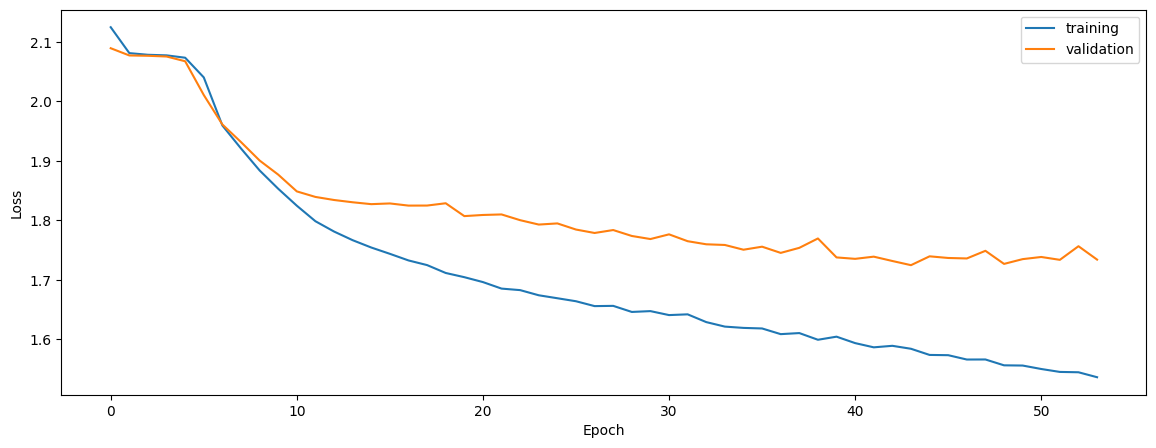

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.3866452735437222


0.33483996644737296


0.2927896964653956


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.32380488440395033


0.3356795651340662


0.23825432796766582


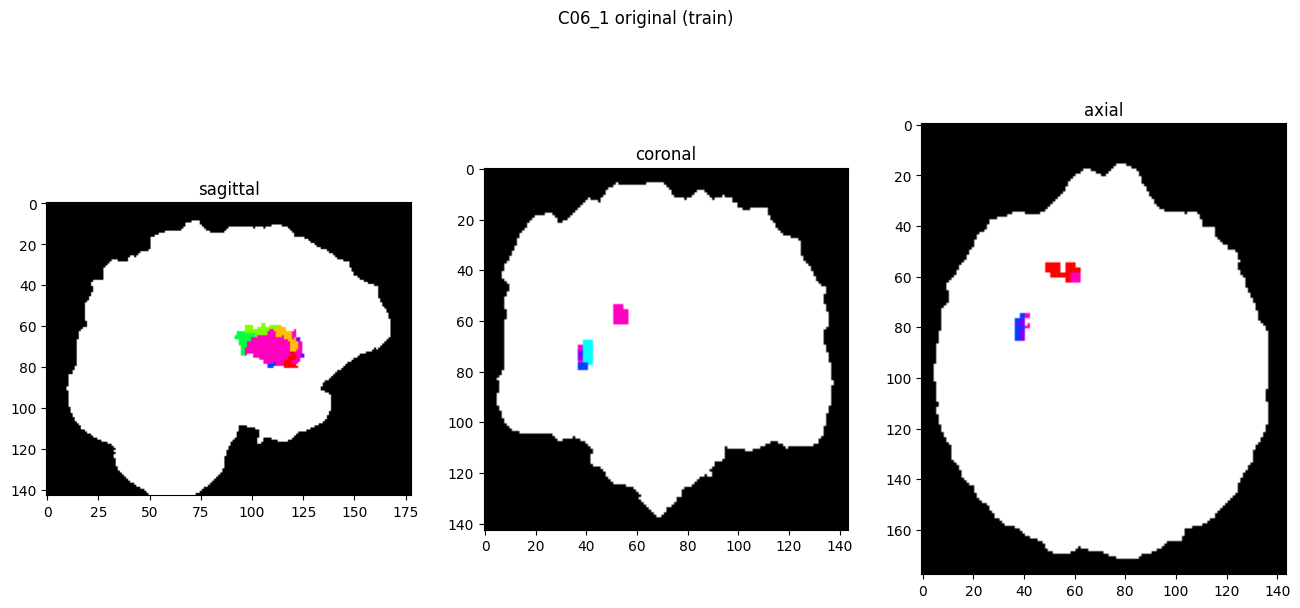

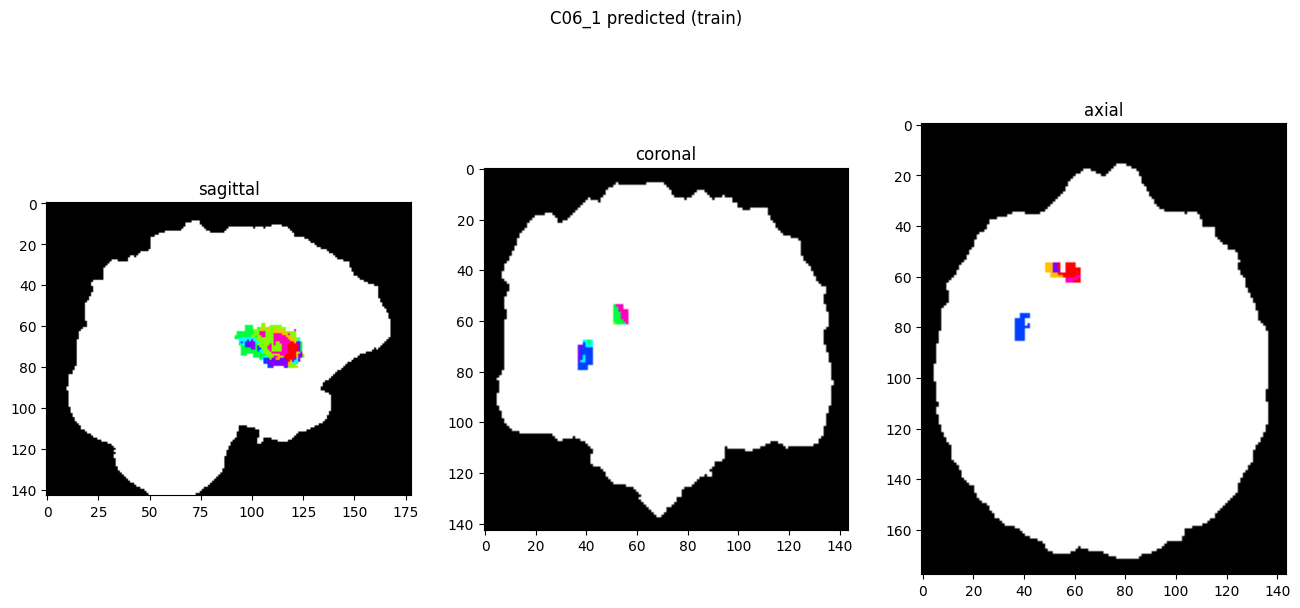

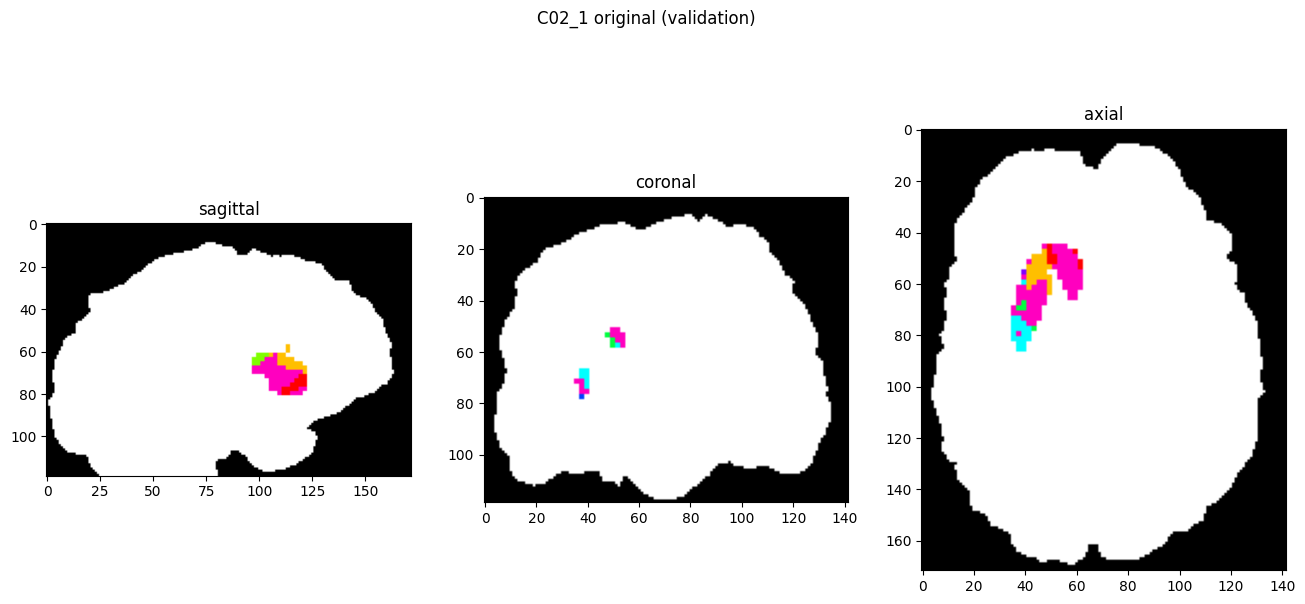

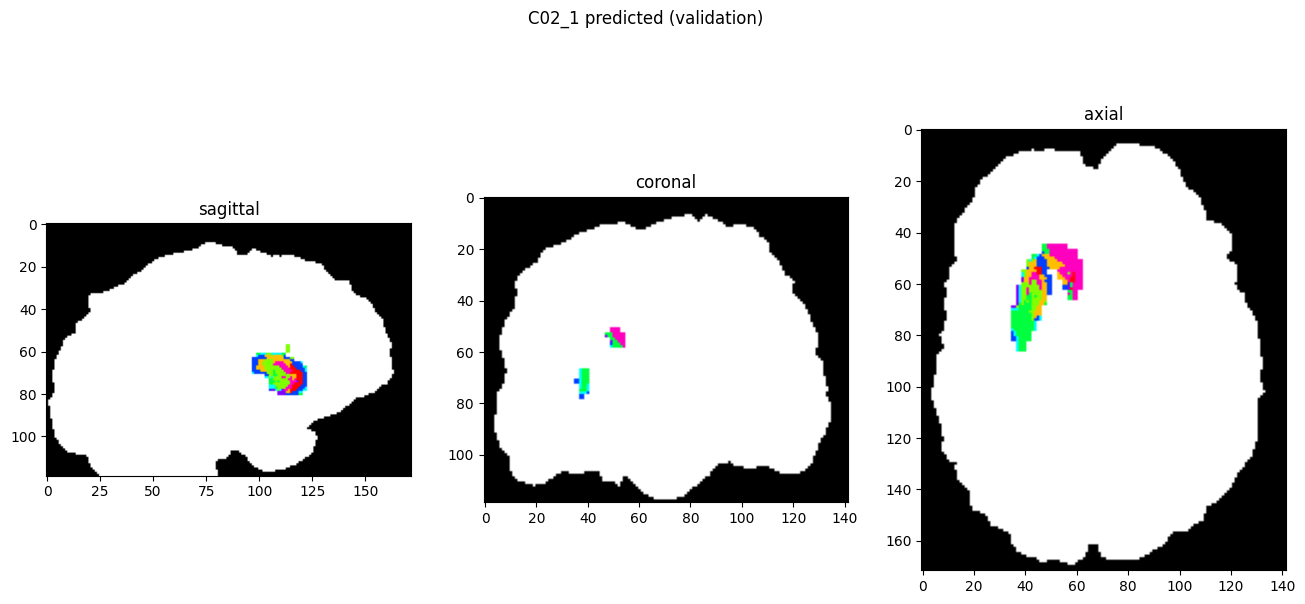

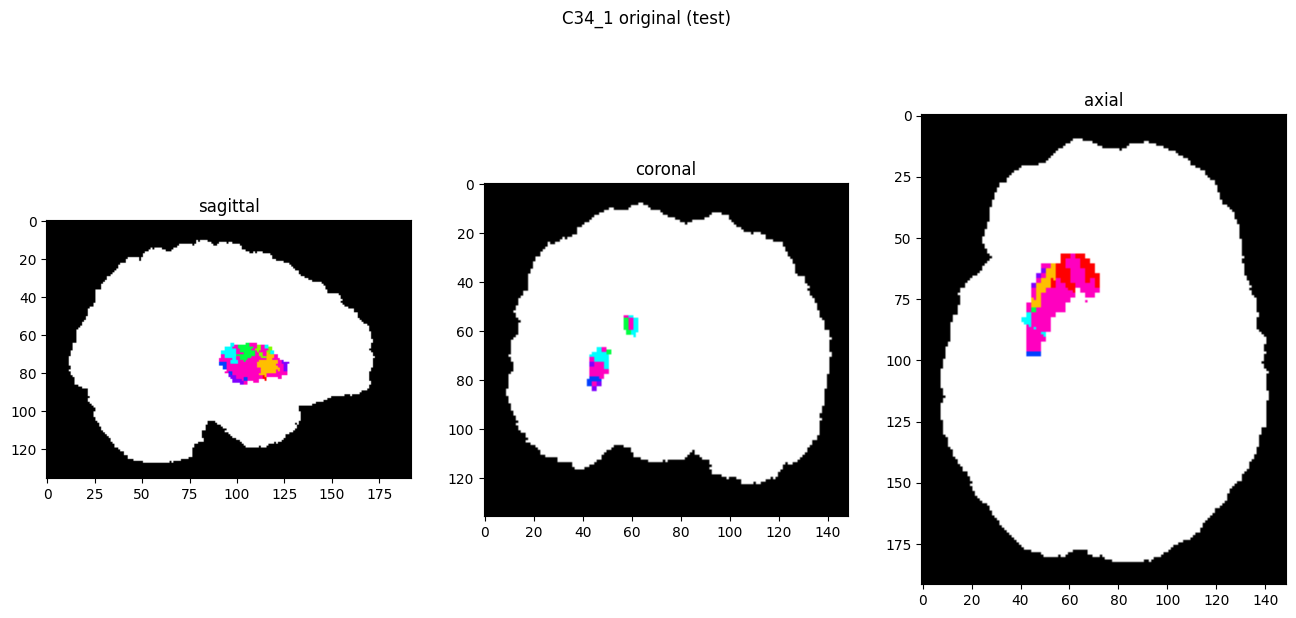

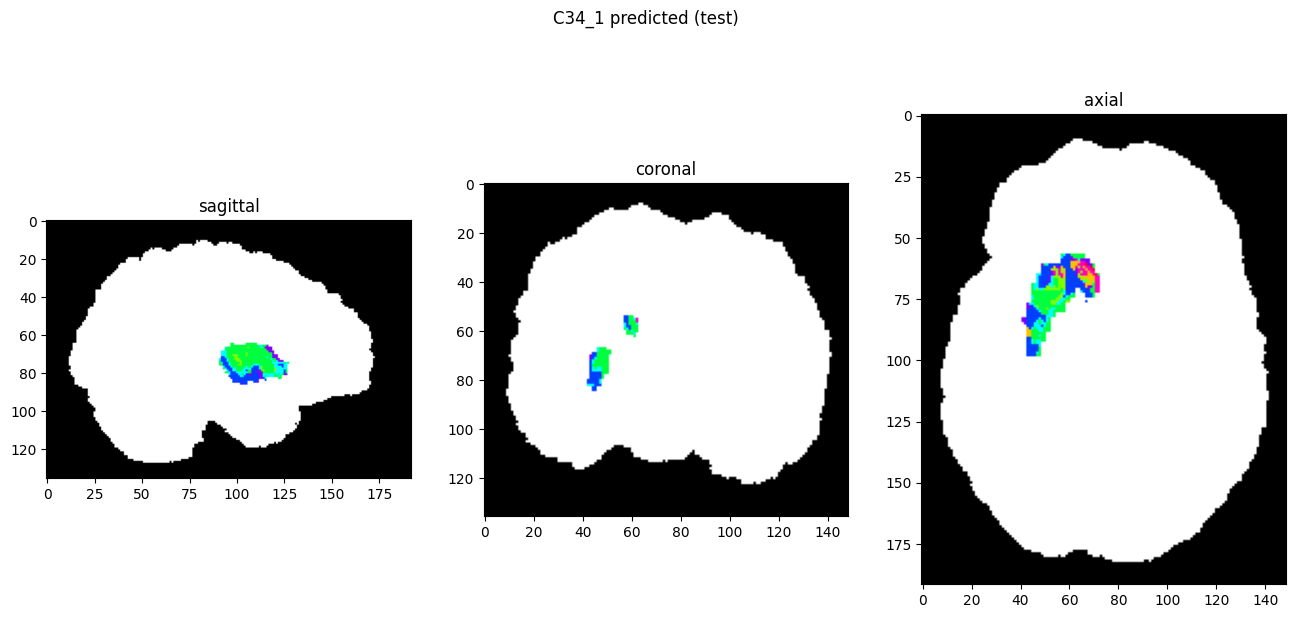

In [9]:
showResults(model, gen, threshold=0)